# Сборный проект №2

# HR-аналитика компании "Работа с заботой"

**Описание проекта:**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — **уровень удовлетворённости сотрудника работой в компании**. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

**Цель проекта:**

**1.** Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

**Почему бизнесу это важно:** удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**2.** Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Описание данных для 1 цели:**

Для реализации первой цели заказчик предоставил следующие данные с признаками:

Данные представлены в следующих файлах: *'train_job_satisfaction_rate.csv', 'test_features.csv', 'test_target_job_satisfaction_rate.csv'.*
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, **целевой признак**.

**Описание данных для 2 цели:**

Для реализации второй цели можно использовать те же входные признаки, что и в предыдущей задаче. 

Однако целевой признак отличается: это **quit** — увольнение сотрудника из компании.

Данные представлены в следующих файлах: *'train_quit.csv', 'test_features.csv', 'test_target_quit.csv'.*

**План работы с проектом:**
1. Загрузка и изучение данных;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Проведение корреляционного анализа данных;
5. Подготовка данных;
6. Обучение моделей;
7. Формирование итоговых выводов.

Данный путь реализации действий можно использовать для выполнения первой и второй целей.

# Цель №1. Предсказание уровня удовлетворённости сотрудника

## 1. Загрузка и изучение данных

In [1]:
# скачаем дополнительные библиотеки, необходимые для работы
!pip install shap -q
!pip -q install phik

In [2]:
# загрузим стандартные библиотеки, необходимые для работы
import pandas as pd
import math
import sklearn
import numpy as np
from scipy import stats as st

# загрузим библиотеки для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns

# загрузим модули для работыы над конкретной задачей
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
import phik
import shap
import warnings
warnings.filterwarnings("ignore")

# введем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

### 1.1 Загрузка и изучение данных файла "train_job_satisfaction_rate.csv"

In [3]:
# загрузим из файла 'train_job_satisfaction_rate.csv' данные тренировочной выборки
# для удобства работы будем вводить сразу подходящие переменные для построения моделей
try:
    # локальный путь к файлу
    data = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Сборный_проект_№2/train_job_satisfaction_rate.csv')
except:
    # путь к файлу в тренажере
    data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')

# посмотрим первые 5 строк датафрема
data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
# посмотрим общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, типы данных в столбцах корректные. В данных присутствуют пропуски в столбцах 'dept' и 'level'. 

### 1.2 Загрузка и изучение данных файла "test_features.csv"

In [5]:
# загрузим из файла 'test_features.csv' входные признаки тестовой выборки
# для удобства работы будем вводить сразу подходящие переменные для построения моделей
try:
    # локальный путь к файлу
    X_test = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Сборный_проект_№2/test_features.csv')
except:
    # путь к файлу в тренажере
    X_test = pd.read_csv('/datasets/test_features.csv')

# посмотрим первые 5 строк датафрема
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
# посмотрим общую информацию о данных
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи *(представлены все входные признаки тестовой выборки)*, типы данных в столбцах корректные. В данных присутствуют пропуски в столбцах 'dept' и 'level'. 

### 1.3 Загрузка и изучение данных файла "test_target_job_satisfaction_rate.csv"

Целевой признак: **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании.

In [7]:
# загрузим из файла 'test_target_job_satisfaction_rate.csv' целевой признак тестовой выборки
# для удобства работы будем вводить сразу подходящие переменные для построения моделей
try:
    # локальный путь к файлу
    y_test = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Сборный_проект_№2/test_target_job_satisfaction_rate.csv')
except:
    # путь к файлу в тренажере
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

# посмотрим первые 5 строк датафрема
y_test.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
# посмотрим общую информацию о данных
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи *(представлен целевой признак тестовой выборки)*, типы данных в столбцах корректные. Пропуски отсутствуют. Также можно заметить, что порядок 'id' в выборках 'X_test' и 'y_test' не совпадает *(необходимо исправить)*.

**Обобщающий вывод этапа "Загрузка и изучение данных":** 
1. Данные во всех таблицах соответсвуют описанию задачи.
2. В таблицах 'data' и 'X_test' присутствуют пропуски в столбцах 'dept' и 'level'.
3. В каждой таблице названия столбцов соответветствуют общепринятому стилю.
4. Также можно заметить, что порядок 'id' в выборках 'X_test' и 'y_test' не совпадает *(необходимо исправить)*.

## 2. Предобработка данных

### 2.1 Предобработка данных в таблице "data"

In [9]:
# посмотрим количество пропусков в данных
data.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

**Примечание:** Всего в таблице присутствует 10 пропусков, по условию задачи и для удобства использования построенной модели в будущем они будут заполнены в пайплайне.

In [10]:
# проверим датафрейм на наличие явных дубликатов
data.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутствуют.

In [11]:
# проверим данные на наличие неявных дубликатов в столбцах с категориальными данными
# посмотрим значения в столбцах: 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'
print('Уникальные значения в столбце "dept":', data['dept'].unique())
print('Уникальные значения в столбце "level":', data['level'].unique())
print('Уникальные значения в столбце "workload":', data['workload'].unique())
print('Уникальные значения в столбце "last_year_promo":', data['last_year_promo'].unique())
print('Уникальные значения в столбце "last_year_violations":', data['last_year_violations'].unique())

Уникальные значения в столбце "dept": ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в столбце "level": ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце "workload": ['medium' 'high' 'low']
Уникальные значения в столбце "last_year_promo": ['no' 'yes']
Уникальные значения в столбце "last_year_violations": ['no' 'yes']


In [12]:
# заменим опечатку
data['level'] = data['level'].replace('sinior', 'senior')

# посмотрим уникальные значения в столбцах после замены
print('Уникальные значения в столбце "level":', data['level'].unique())

Уникальные значения в столбце "level": ['junior' 'middle' 'senior' nan]


**Примечание:** Замена проведена успешно.

### 2.2 Предобработка данных в таблице "X_test"

In [13]:
# посмотрим количество пропусков в данных
X_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

**Примечание:** Всего в таблице присутствует 3 пропуска, по условию задачи и для удобства использования построенной модели в будущем они будут заполнены в пайплайне.

In [14]:
# проверим датафрейм на наличие явных дубликатов
X_test.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутствуют.

In [17]:
# проведем сортировку данных для столбца 'id'
X_test = X_test.sort_values(by='id').reset_index(drop=True)

# посмотрим первые 5 строк полученной таблицы
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


**Примечание:** Сортировка индексов проведена успешно.

### 2.3 Предобработка данных в таблице "y_test"

In [18]:
# посмотрим количество пропусков в данных
y_test.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

**Примечание:** Пропуски в данных отсутствуют.

In [19]:
# проверим датафрейм на наличие явных дубликатов
y_test.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутствуют.

In [20]:
# проведем сортировку данных для столбца 'id'
y_test = y_test.sort_values(by='id').reset_index(drop=True)

# посмотрим первые 5 строк полученной таблицы
y_test.head()

,id,job_satisfaction_rate
0,100298,0.80
1,100480,0.84
2,100503,0.79
3,100610,0.75
4,100692,0.69


**Примечание:** Сортировка индексов проведена успешно.

**Обобщающий вывод этапа "Предобработка данных":**
1. В таблицах 'data' и 'X_test' присутствуют пропуски, они будут заполнены на этапе создания пайплайнов.
2. В таблицах отсутствуют явные и неявные дубликаты.
3. В таблицах 'data' и 'X_test' была заменена опечатка 'sinior' на 'senior'.
4. В таблицах 'X_test' и 'y_test' была произведена сортировка по индексам *(теперь они совпадают)*.

## 3. Исследовательский анализ данных

### 3.1 Исследовательский анализ данных таблицы 'data'

In [21]:
# проведем статистический анализ всех признаков в таблице 'data'
print('Описательная статистика для количественных признаков:') 
data.describe(include=[np.number])

Описательная статистика для количественных признаков:


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


**Примечание:** По полученной описательной статистике видно, что данные в столбцах 'employment_years' и 'supervisor_evaluation' являются дискретными, а данные в столбцах 'salary' и 'job_satisfaction_rate' непрерывными, их нужно визуализировать по-разному.

In [22]:
print('Описательная статистика для категориальных признаков:')
data.describe(include=['object'])

Описательная статистика для категориальных признаков:


,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


In [23]:
# построение графиков для разных типов признаков (количественных и категориальных)
# напишем собственную функцию для визулизации категориальных признаков
def categorical(data, column, title, figsize=(6, 3)):
    # устанавливаем параметры графика
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    
    # создаем график
    ax = sns.countplot(data = data, x=column, palette="pastel")
    
    # добавляем процентное соотношение по признакам
    total = len(data)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.01 * total,
                f'{height/total:.1%}',
                ha="center")

    # окончательная настройка графика
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Количество сотрудников')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

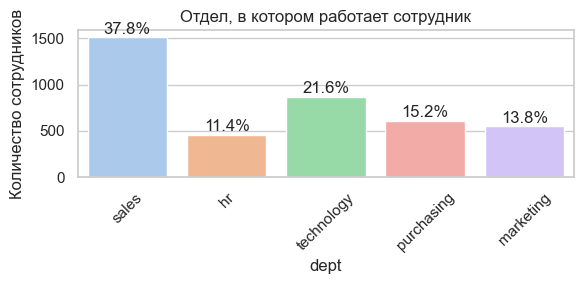

In [24]:
# визуализация признака 'dept'
categorical(data, 'dept', 'Отдел, в котором работает сотрудник')

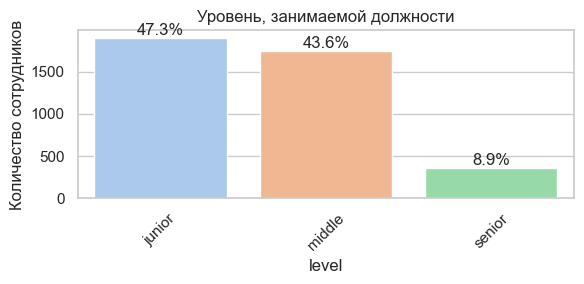

In [25]:
# визуализация признака 'level'
categorical(data, 'level', 'Уровень, занимаемой должности')

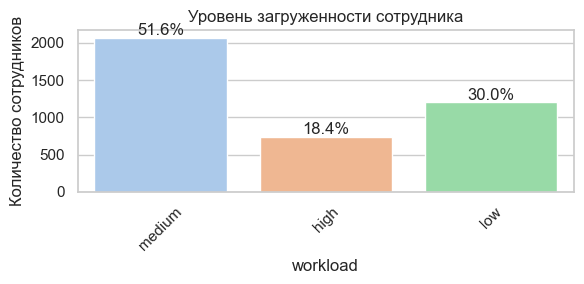

In [26]:
# визуализация признака 'workload'
categorical(data, 'workload', 'Уровень загруженности сотрудника')

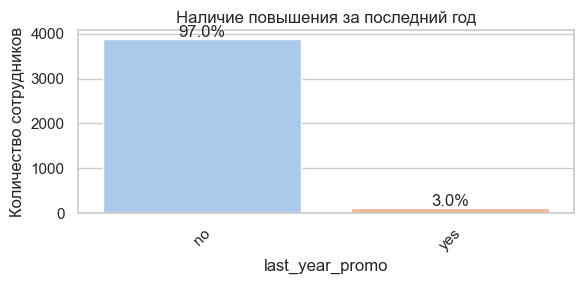

In [27]:
# визуализация признака 'last_year_promo'
categorical(data, 'last_year_promo', 'Наличие повышения за последний год')

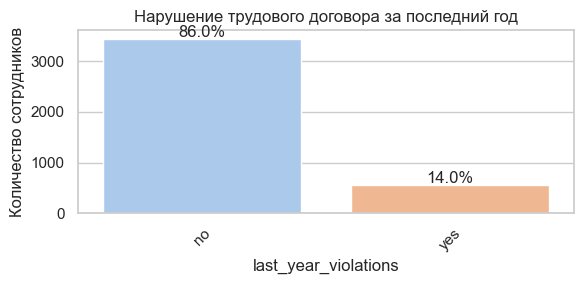

In [28]:
# визуализация признака 'last_year_violations'
categorical(data, 'last_year_violations', 'Нарушение трудового договора за последний год')

In [29]:
# напишем собственную функцию для визуализации дискретных количественных признаков
def discret(data, column, title):
    # устанавливаем параметры графика
    plt.figure(figsize=(15, 3))
    
    # построение гистограммы (countplot) для дискретных количественных признаков
    plt.subplot(1, 2, 1)
    sns.countplot(x=data[column], palette='pastel')
    plt.title(f'Гистограмма распределения для "{column}"')
    plt.xlabel(column)
    plt.ylabel('Количество сотрудников')
    
    # построение графика "Ящик с усами"
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color='lightblue')
    plt.title(f'Ящик с усами для "{column}"')
    plt.xlabel(column)

    # окончательная настройка графика
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

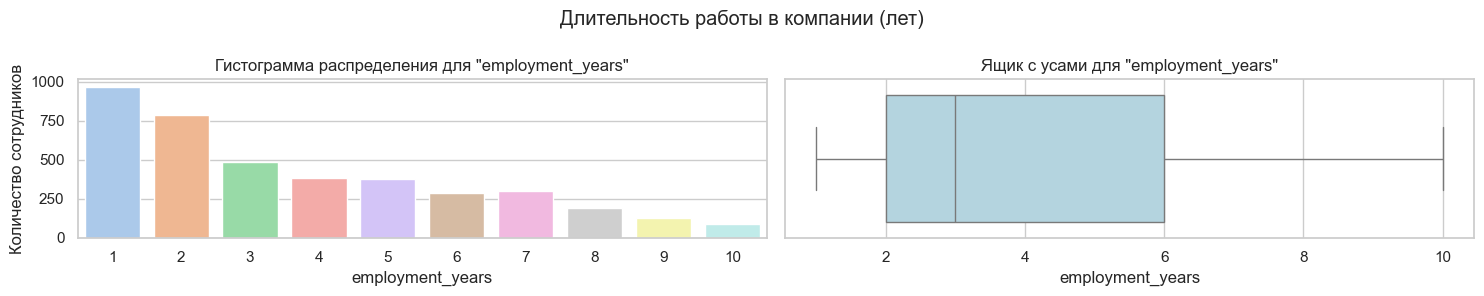

In [30]:
# визуализация признака 'employment_years'
discret(data, 'employment_years', 'Длительность работы в компании (лет)')

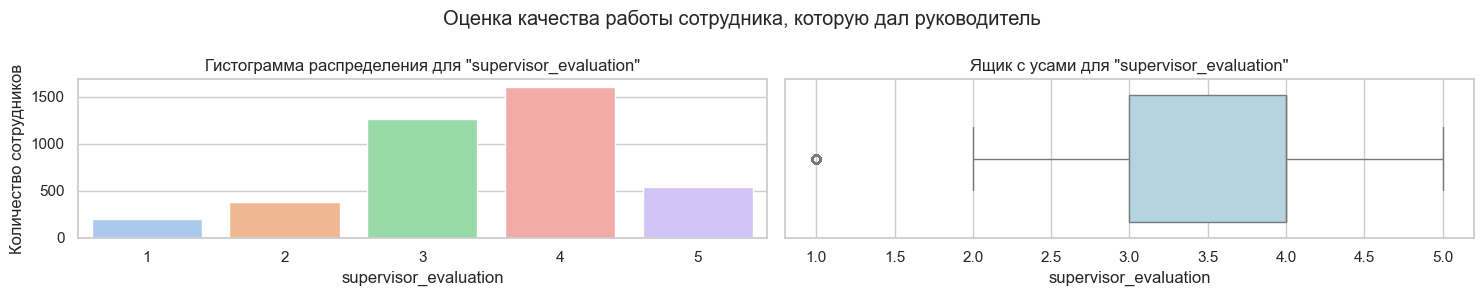

In [31]:
# визуализация признака 'supervisor_evaluation'
discret(data, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель')

In [32]:
# напишем собственную функцию для визуализации непрерывных количественных признаков
def numeric(data, column, title):
    # устанавливаем параметры графика
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
    
    # построение гистограммы для непрерывных количественных признаков 
    sns.histplot(data, x=column, bins=20, kde=True, ax=ax1, color='lightpink')
    ax1.set_title(f'Гистограмма для {column}')
    ax1.set_ylabel('Количество сотрудников')
    
    # построение графика "Ящик с усами"
    sns.boxplot(data=data, x=column, ax=ax2, color='lightblue')
    ax2.set_title(f'Ящик с усами для {column}')
    ax2.set_xlabel(column)
    
    # окончательная настройка графика
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

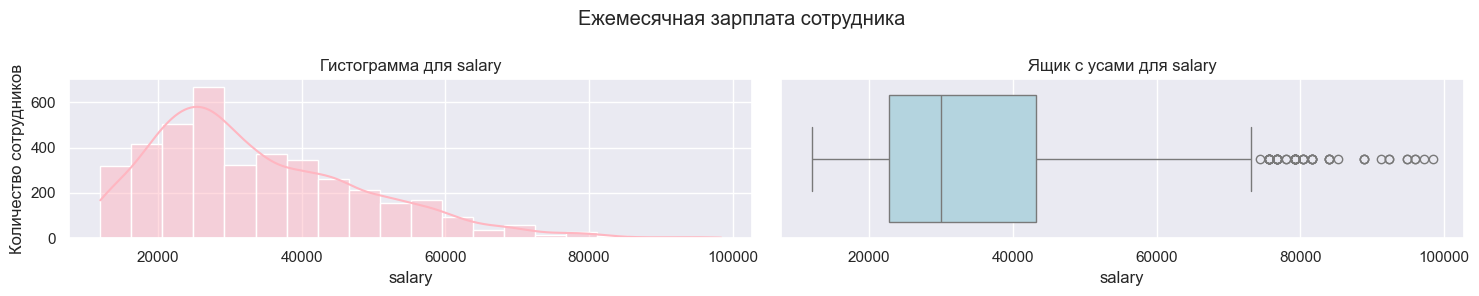

In [33]:
# визуализация признака 'salary'
numeric(data, 'salary', 'Ежемесячная зарплата сотрудника')

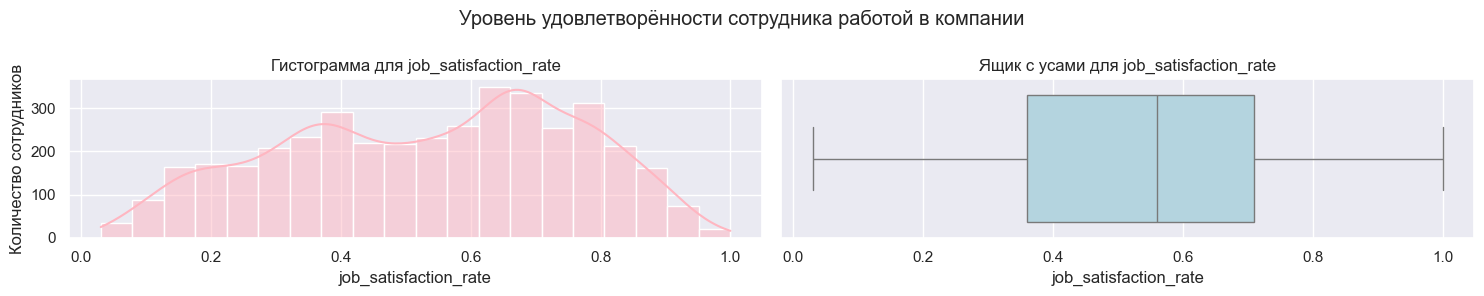

In [34]:
# визуализация признака 'job_satisfaction_rate' (целевой признак)
numeric(data, 'job_satisfaction_rate', 'Уровень удовлетворённости сотрудника работой в компании')

**Промежуточные выводы по этапу "Исследовательский анализ данных таблицы 'data'":**

1. Можно сказать, что входящие в таблицу категориальные признаки несбалансированы, прослеживается тенденция, что одни категории встречаются намного чаще других.
2. Дискретный количественный признак 'employment_years' имеет смещение влево и не имеет выбросов.
3. Дискретный количественный признак 'supervisor_evaluation' имеет распределение с обрезанным правым концом.
4. Непрервыный количественный признак 'salary' имеет распредение, смещенное влево, и некоторый перечень аномально больших значений *(пока что не будем их удалять)*.
5. Непрервыный количественный признак 'job_satisfaction_rate' имеет распределение без выбросов.

### 3.2 Исследовательский анализ данных таблицы 'X_test'

In [35]:
# проведем статистический анализ всех признаков в таблице 'X_test'
print('Описательная статистика для количественных признаков:')
X_test.describe(include=[np.number])

Описательная статистика для количественных признаков:


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


**Примечание:** По полученной описательной статистике видно, что данные в столбцах 'employment_years' и 'supervisor_evaluation' являются дискретными, а данные в столбце 'salary' непрерывными, их нужно визуализировать по-разному.

In [36]:
print('Описательная статистика для категориальных признаков:')
X_test.describe(include=['object'])

Описательная статистика для категориальных признаков:


,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


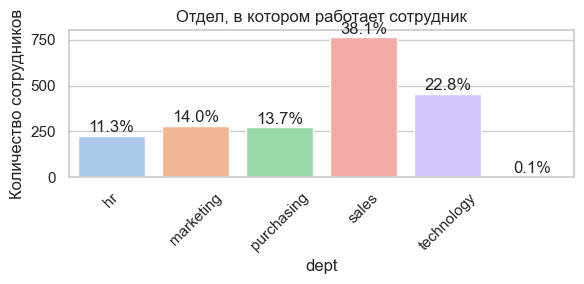

In [37]:
# визуализация признака 'dept'
categorical(X_test, 'dept', 'Отдел, в котором работает сотрудник')

In [38]:
# посмотрим пропущенное значение, которое составляет 0.1% от общего количества
# X_test[X_test['dept'] == ' ']

In [39]:
# заменим пропуск на значение 'sales'
# X_test['dept'] = X_test['dept'].replace(' ', 'sales')

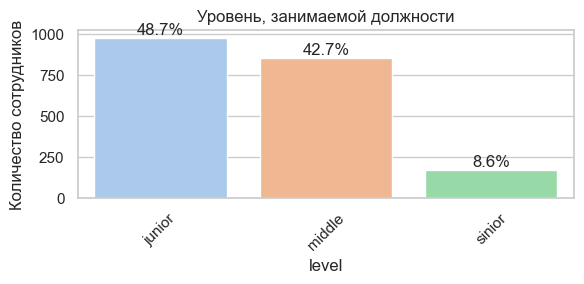

In [40]:
# визуализация признака 'level'
categorical(X_test, 'level', 'Уровень, занимаемой должности')

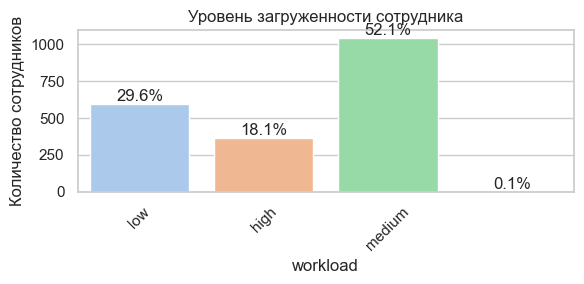

In [41]:
# визуализация признака 'workload'
categorical(X_test, 'workload', 'Уровень загруженности сотрудника')

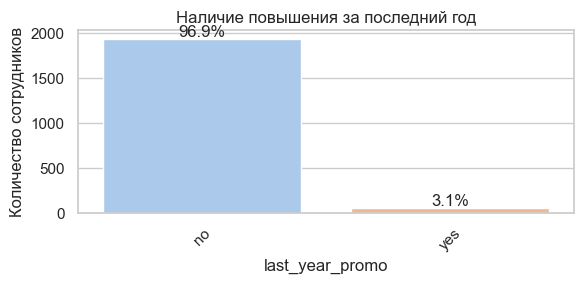

In [44]:
# визуализация признака 'last_year_promo'
categorical(X_test, 'last_year_promo', 'Наличие повышения за последний год')

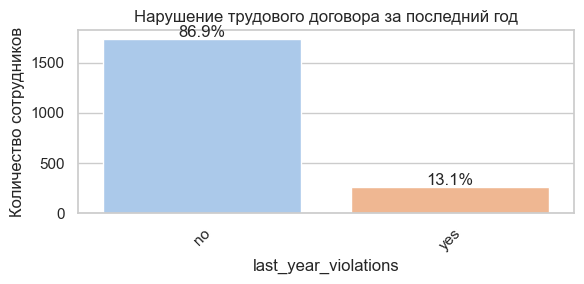

In [45]:
# визуализация признака 'last_year_violations'
categorical(X_test, 'last_year_violations', 'Нарушение трудового договора за последний год')

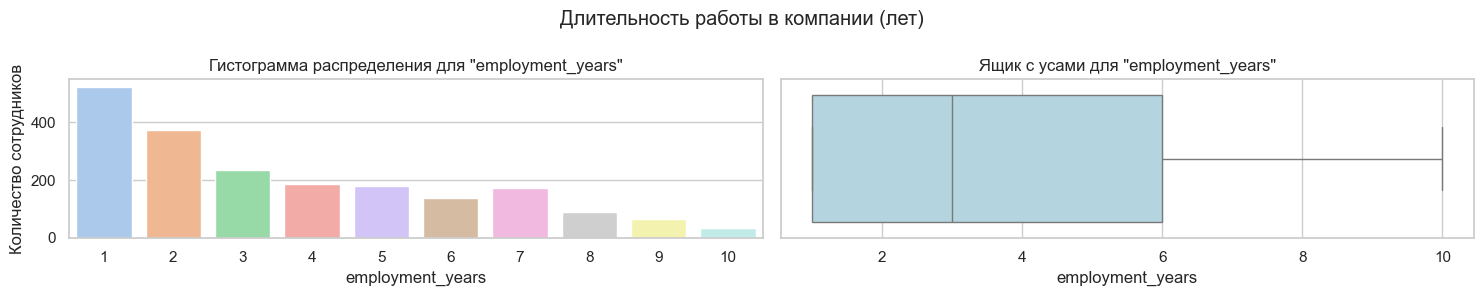

In [46]:
# визуализация признака 'employment_years'
discret(X_test, 'employment_years', 'Длительность работы в компании (лет)')

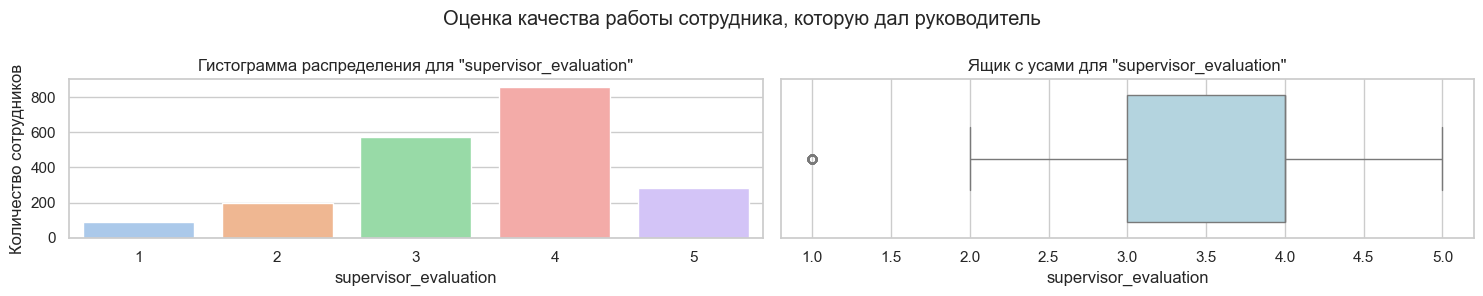

In [47]:
# визуализация признака 'supervisor_evaluation'
discret(X_test, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель')

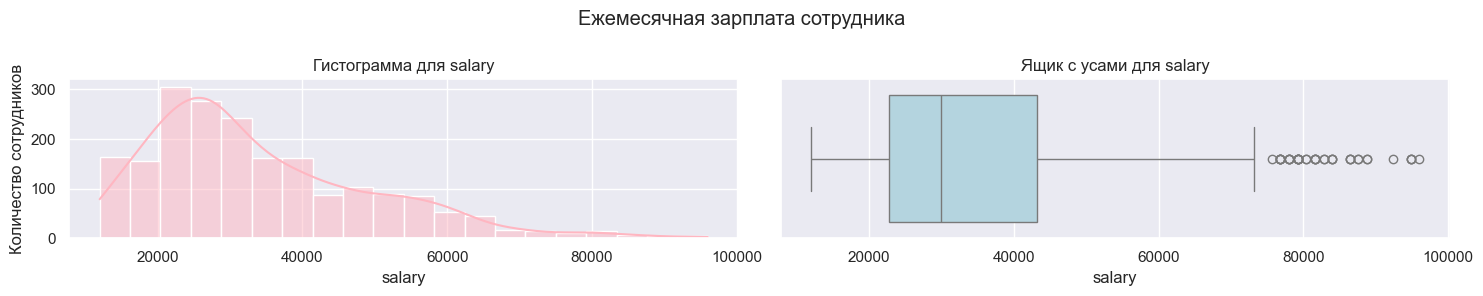

In [48]:
# визуализация признака 'salary'
numeric(X_test, 'salary', 'Ежемесячная зарплата сотрудника')

**Промежуточные выводы по этапу "Исследовательский анализ данных таблицы 'X_test'":**

1. Категориальные признаки в тестовой выборке имеют распределение похожее на то, что получилось на тренировочной выборке.
2. Распределения количественных признаков на тестовой выборке схожи с теми, что получились на тренировочной выборке. Это говорит о том, что предварительная разбивка на тренировочную и тестовую выборки была проведена успешно.
3. Дискретный количественный признак 'employment_years' имеет распределение, смещенное влево, и не имеет выбросов.
4. Дискретный количественный признак 'supervisor_evaluation' имеет распределение с обрезанным правым концом.
5. Непрерывный количественный признак 'salary' имеет распределение, смещенное влево, и некоторый перечень аномально больших значений *(пока что удалять их не будем)*.

### 3.3 Исследовательский анализ данных таблицы 'y_test'

In [49]:
# проведем статистический анализ всех признаков в таблице 'y_test'
print('Описательная статистика для количественных признаков:')
y_test.describe(include=[np.number])

Описательная статистика для количественных признаков:


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


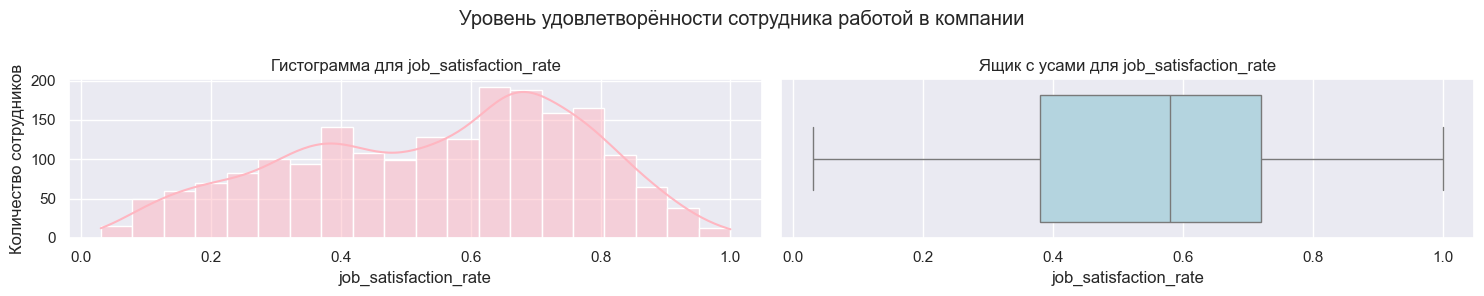

In [50]:
# визуализация признака 'job_satisfaction_rate' (целевой признак)
numeric(y_test, 'job_satisfaction_rate', 'Уровень удовлетворённости сотрудника работой в компании')

**Промежуточные выводы по этапу "Исследовательский анализ данных таблицы 'y_test'":**
1. Распределение целевого признака на тестовой выборке схоже с распределением этого же признака на тренировочной выборке.
2. Целевой признак 'job_satisfaction_rate' имеет практически нормальное распределение и не имеет вовсе выбросов.

**Обобщающий вывод этапа "Исследовательский анализ данных":**

1. Среди категориальных признаков присутствует дисбаланс, о чем говорит факт того, что некоторые категории встречаются значительно чаще других.
2. Распределения количественных признаков на тестовой выборке схожи с теми, что получились на тренировочной выборке. Это говорит о том, что предварительная разбивка на тренировочную и тестовую выборки была проведена успешно.
3. Распределение целевого признака на тестовой выборке схоже с распределением этого же признака на тренировочной выборке.

## 4. Проведение корреляционного анализа данных

### 4.1 Проведение корреляционного анализа признаков таблицы 'data'

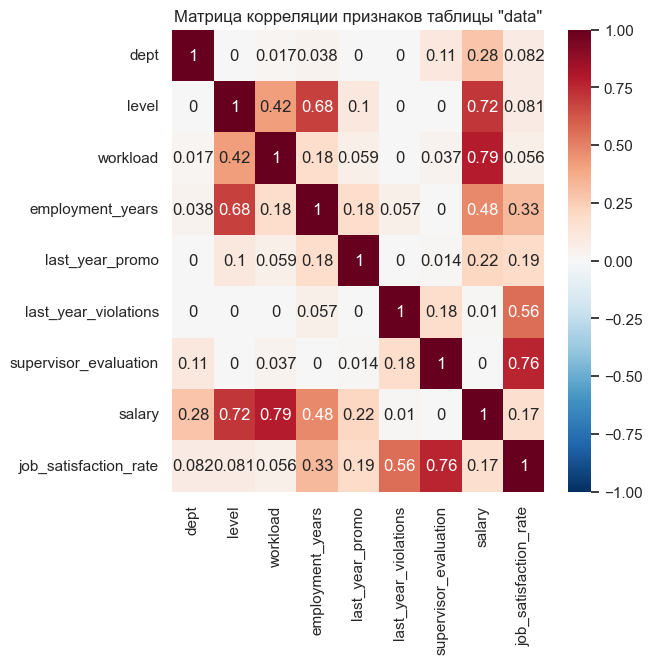

In [51]:
# удалим столбец 'id', так как он не нужен в процессе вычисления корреляции между признаками
data_corr_matrix = data.drop(['id'], axis=1)

# построим корреляционную матрицу, заранее обозначая столбцы с непрерывными количественными значениями
data_corr_matrix = data_corr_matrix.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

# проведем визуализацию корреляционной матрицы
# построим тепловую карту
plt.figure(figsize=(6, 6))
sns.heatmap(
    data_corr_matrix,
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)

# окончательная настройка графика
plt.title('Матрица корреляции признаков таблицы "data"')
plt.show()

**Промежуточные выводы по этапу "Проведение корреляционного анализа признаков таблицы 'data'":**

По полученной матрице видно, что:

1. Признаки 'level' (уровень занимаемой должности) и 'employment_years' (длительность работы в компании) имеют высокое значение коэффициента корреляции, равное 0.68.
2. Признаки 'level' (уровень занимаемой должности) и 'salary' (ежемесячная зарплата сотрудника) имеют высокое значение коэффициента корреляции, равное 0.72.
3. Признаки 'salary' (ежемесячная зарплата сотрудника) и 'workload' (уровень загруженности сотрудника) имеют высокое значение коэффициента корреляции, равное 0.79.
4. Целевой признак 'job_satisfaction_rate' (уровень удовлетворённости сотрудника работой в компании) и признаки 'supervision_evaluation' (оценка качества работы сотрудника, которую дал руководитель), 'last_year_violations' (нарушения сотрудником трудового договора за последний год) имеют высокие значения коэффициентов корреляции, равные 0.76 и 0.56 соответственно, но данное явление не является мильтиколлинеарностью.

### 4.2 Проведение корреляционного анализа признаков таблицы 'X_test'

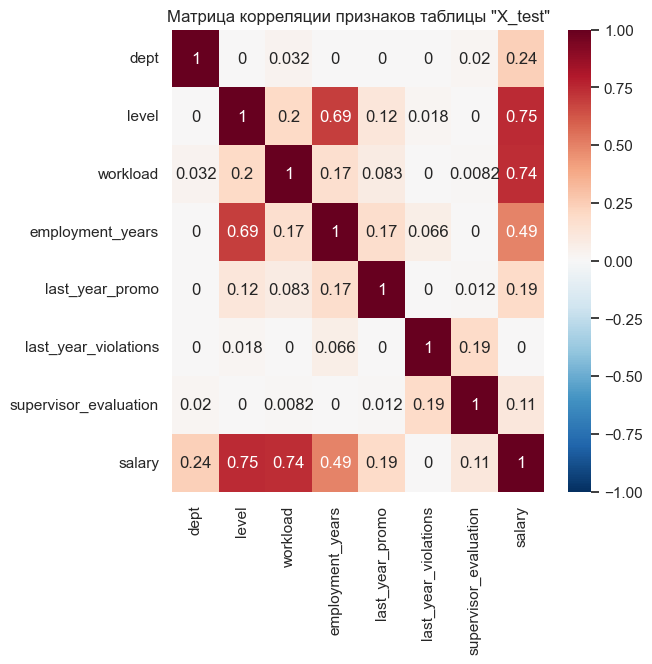

In [52]:
# удалим столбец 'id', так как он не нужен в процессе вычисления корреляции между признаками
X_test_corr_matrix = X_test.drop(['id'], axis=1)

# построим корреляционную матрицу, заранее обозначая столбцы с непрерывными количественными значениями
X_test_corr_matrix = X_test_corr_matrix.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

# проведем визуализацию корреляционной матрицы
# построим тепловую карту
plt.figure(figsize=(6, 6))
sns.heatmap(
    X_test_corr_matrix,
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)

# окончательная настройка графика
plt.title('Матрица корреляции признаков таблицы "X_test"')
plt.show()

**Промежуточные выводы по этапу "Проведение корреляционного анализа признаков таблицы 'X_test'":** Проведенный корреляционный анализ для тестовой выборки продемонстрировал аналогичные результаты, как на тренировочной выборке.

**Обобщающий вывод этапа "Проведение корреляционного анализа":**

Для признаков таблицы 'data' (тренировочная выборка):
1. Признаки 'level' (уровень занимаемой должности) и 'employment_years' (длительность работы в компании) имеют высокое значение коэффициента корреляции, равное 0.68.
2. Признаки 'level' (уровень занимаемой должности) и 'salary' (ежемесячная зарплата сотрудника) имеют высокое значение коэффициента корреляции, равное 0.72.
3. Признаки 'salary' (ежемесячная зарплата сотрудника) и 'workload' (уровень загруженности сотрудника) имеют высокое значение коэффициента корреляции, равное 0.79.
4. Целевой признак 'job_satisfaction_rate' (уровень удовлетворённости сотрудника работой в компании) и признаками 'supervision_evaluation' (оценка качества работы сотрудника, которую дал руководитель), 'last_year_violations' (нарушения сотрудником трудового договора за последний год), равное 0.76 и 0.56 соответственно, но данное явление не является мильтиколлинеарностью.

Для признаков таблицы 'X_test' (тестовая выборка): Проведенный корреляционный анализ для тестовой выборки продемонстрировал аналогичные результаты, как на тренировочной выборке.

## 5. Подготовка данных

In [53]:
# удалим из таблицы, содержащую тренировочную выборку столбец 'id'
pre_data = data.drop('id', axis=1)

**Примечание:** Так как столбец 'id' с неповторяющимися значениями индексов был удален, происходит уменьшение количества исследуемых значений в целом. В связи с этим могут появиться новые явные дубликаты. Это необходимо проверить и удалить при появлении.

In [54]:
# проверим новую таблицу на наличие явных дубликатов
pre_data.duplicated().sum()

np.int64(245)

In [55]:
# удалим все явные дубликаты в новой таблице, так как они будут мешать дальнейшему качественному построению моделей
pre_data = pre_data.drop_duplicates()

# проверим новую таблицу на наличие явных дубликатов
pre_data.duplicated().sum()

np.int64(0)

**Обобщающий вывод этапа "Подготовка данных":** На данном этапе была проведена подготовка данных для дальнейшего обучения.

## 6. Обучение моделей

**Примечание:** Целевой признак 'job_satisfaction_rate' выражен непрерывными количественными значениями, поэтому в качестве моделей будем использовать модель линейной регрессиии и модель дерева решений для задач регрессии.

### 6.1 Создание пайплайна и обучение моделей

In [56]:
# создаем тренировочную и тестовую выборки на основе исходных данных
# создаем тренировочную выборку
X_train = pre_data.drop('job_satisfaction_rate', axis=1)
y_train = pre_data['job_satisfaction_rate']
# создаем тестовую выборку
X_test = X_test.drop('id', axis=1)
y_test = y_test['job_satisfaction_rate']

# создаем списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# создаем пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

# создаем пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', 
         data_preprocessor
        ),
        ('models', 
        DecisionTreeRegressor(random_state=RANDOM_STATE)
        )
    ]
)

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

# создаем собственную метрику для оценки качества модели SMAPE («симметричное среднее абсолютное процентное отклонение»)
# напишем собственную функцию для создания метрики
def SMAPE(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))))

# укажем критерии успешности метрики
SMAPE_score = make_scorer(SMAPE, greater_is_better=False)

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=SMAPE_score,
    n_jobs=-1
)

# обучение модели на основе тренировочной выборки
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика SMAPE для лучшей модели по кросс-валидации на основе обучающих данных:', grid_search.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [57]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred = grid_search.predict(X_test)
y_true = y_test

print(f'Метрика SMAPE на тестовой выборке: {SMAPE(y_true, y_pred)}')

Метрика SMAPE на тестовой выборке: 14.910539089823084


### 6.2 Анализ важности признаков

PermutationExplainer explainer: 3756it [02:16, 27.57it/s]                                                              


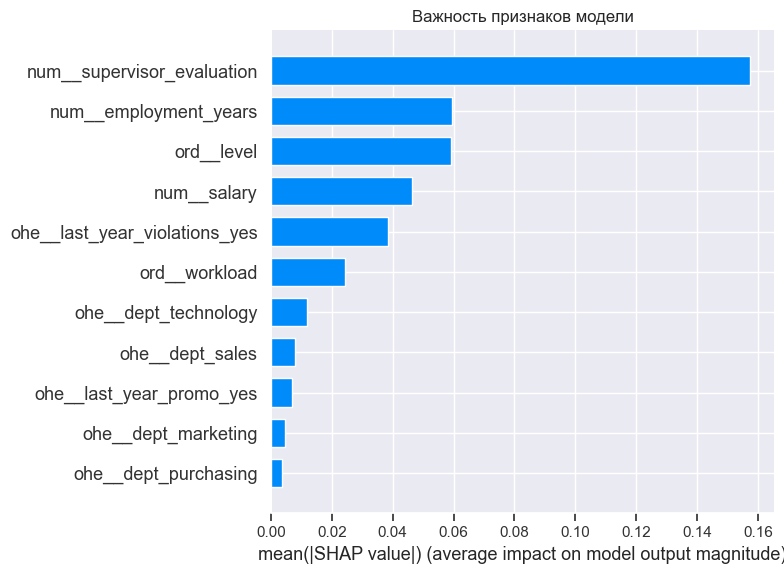

In [58]:
# достанем компоненты пайплайна
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
model = grid_search.best_estimator_.named_steps['models']

# преобразуем данные и обучаем модель
X_encoded = preprocessor.fit_transform(X_train)
model.fit(X_encoded, y_train)

# создаем "Еxplainer" и вычисляем SHAP значения
explainer = shap.PermutationExplainer(model.predict, X_encoded)
shap_values = explainer(X_encoded)

# проводим визуализацию важности признаков
shap.summary_plot(
    shap_values=shap_values,
    plot_type='bar',
    feature_names=preprocessor.get_feature_names_out(),
    show=False
)

# окончательная настройка графика
plt.title('Важность признаков модели')
plt.tight_layout()
plt.show()

## 7. Итоговый вывод по цели №1 "Предсказание уровня удовлетворенности сотрудника"

**Обобщающий вывод по цели №1 "Предсказание уровня удовлетворенности сотрудника":**

1. Наилучшей моделью оказалась **DecisionTreeRegressor()** с параметрами: (max_depth=13, random_state=42)).
2. Метрика SMAPE на тестовой выборке равна 14.91, что удовлетворяет требованиям реализации цели, так как по условия метрика SMAPE ≤ 15 на тестовой выборке.
3. По графику "Важность признаков модели" стало видно, что наиболее важными признаками при построении модели, которые влияют на целевой признак, являются 'supervisor_evaluation' (оценка качества работы сотрудника, которую дал руководитель), 'employment_years' (длительность работы в компании (лет)) и 'level' (уровень занимаемой должности).
4. Можно предположить, что среди двух рассмотренных моделей эта оказалась лучше, чем LinearRegression(), потому что, возможно, могут присутствовать нелинейные зависимости между входными признаками и целевым признаком.

# Цель №2. Предсказание увольнения сотрудника из компании

## 8. Загрузка и изучение данных

### 8.1 Загрузка и изучение данных файла "train_quit.csv"

In [59]:
# загрузим из файла 'train_quit.csv' данные тренировочной выборки
# для удобства работы будем вводить сразу подходящие переменные для построения моделей
try:
    # локальный путь к файлу
    data_quit = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Сборный_проект_№2.1/train_quit.csv')
except:
    # путь к файлу в тренажере
    data_quit = pd.read_csv('/datasets/train_quit.csv')

# посмотрим первые 5 строк датафрема
data_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [60]:
# посмотрим общую информацию о данных
data_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, типы данных в столбцах корректные. Пропуски в данных отсутствуют.

### 8.2 Загрузка и изучение данных файла "test_features.csv"

In [61]:
# загрузим из файла 'test_features.csv' входные признаки тестовой выборки
# для удобства работы будем вводить сразу подходящие переменные для построения моделей
try:
    # локальный путь к файлу
    X_test_quit = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Сборный_проект_№2.1/test_features.csv')
except:
    # путь к файлу в тренажере
    X_test_quit = pd.read_csv('/datasets/test_features.csv')

# посмотрим первые 5 строк датафрема
X_test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [62]:
# посмотрим общую информацию о данных
X_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи *(представлены все входные признаки тестовой выборки)*, типы данных в столбцах корректные. В данных присутствуют пропуски в столбцах 'dept' и 'level'. 

### 8.3 Загрузка и изучение данных файла "test_target_quit.csv"

Целевой признак: **quit** — увольнение сотрудника из компании.

In [63]:
# загрузим из файла 'test_target_quit.csv' целевой признак тестовой выборки
# для удобства работы будем вводить сразу подходящие переменные для построения моделей
try:
    # локальный путь к файлу
    y_test_quit = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Сборный_проект_№2.1/test_target_quit.csv')
except:
    # путь к файлу в тренажере
    y_test_quit = pd.read_csv('/datasets/test_target_quit.csv')

# посмотрим первые 5 строк датафрема
y_test_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [64]:
# посмотрим общую информацию о данных
y_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи *(представлен целевой признак тестовой выборки)*, типы данных в столбцах корректные. Пропуски отсутствуют. Также можно заметить, что порядок 'id' в выборках 'X_test' и 'y_test' не совпадает *(необходимо исправить)*.

**Обобщающий вывод этапа "Загрузка и изучение данных":** 
1. Данные во всех таблицах соответсвуют описанию задачи.
2. В таблице 'X_test_quit' присутствуют пропуски в столбцах 'dept' и 'level'.
3. В каждой таблице названия столбцов соответветствуют общепринятому стилю.
4. Также можно заметить, что порядок 'id' в выборках 'X_test_quit' и 'y_test_quit' не совпадает *(необходимо исправить)*.

## 9. Предобработка данных

### 9.1 Предобработка данных в таблице "data_quit"

In [65]:
# посмотрим количество пропусков в данных
data_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

**Примечание:** Пропуски в таблице отсутствуют.

In [66]:
# проверим датафрейм на наличие явных дубликатов
data_quit.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутствуют.

In [67]:
# проверим данные на наличие неявных дубликатов в столбцах с категориальными данными
# посмотрим значения в столбцах: 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'
print('Уникальные значения в столбце "dept":', data_quit['dept'].unique())
print('Уникальные значения в столбце "level":', data_quit['level'].unique())
print('Уникальные значения в столбце "workload":', data_quit['workload'].unique())
print('Уникальные значения в столбце "last_year_promo":', data_quit['last_year_promo'].unique())
print('Уникальные значения в столбце "last_year_violations":', data_quit['last_year_violations'].unique())

Уникальные значения в столбце "dept": ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в столбце "level": ['middle' 'junior' 'sinior']
Уникальные значения в столбце "workload": ['high' 'medium' 'low']
Уникальные значения в столбце "last_year_promo": ['no' 'yes']
Уникальные значения в столбце "last_year_violations": ['no' 'yes']


In [68]:
# заменим опечатку
data_quit['level'] = data_quit['level'].replace('sinior', 'senior')

# посмотрим уникальные значения в столбцах после замены
print('Уникальные значения в столбце "level":', data_quit['level'].unique())

Уникальные значения в столбце "level": ['middle' 'junior' 'senior']


**Примечание:** Замена проведена успешно.

### 9.2 Предобработка данных в таблице "X_test_quit"

In [69]:
# посмотрим количество пропусков в данных
X_test_quit.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

**Примечание:** Всего в таблице присутствует 3 пропуска, по условию задачи и для удобства использования построенной модели в будущем они будут заполнены в пайплайне.

In [70]:
# проверим датафрейм на наличие явных дубликатов
X_test_quit.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутствуют.

In [73]:
# проведем сортировку данных для столбца 'id'
X_test_quit = X_test_quit.sort_values(by='id').reset_index(drop=True)

# посмотрим первые 5 строк полученной таблицы
X_test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


**Примечание:** Сортировка индексов проведена успешно.

### 9.3 Предобработка данных в таблице "y_test_quit"

In [74]:
# посмотрим количество пропусков в данных
y_test_quit.isna().sum()

id      0
quit    0
dtype: int64

**Примечание:** Пропуски в данных отсутствуют.

In [75]:
# проверим датафрейм на наличие явных дубликатов
y_test_quit.duplicated().sum()

np.int64(0)

**Примечание:** Явные дубликаты в данных отсутствуют.

In [76]:
# проведем сортировку данных для столбца 'id'
y_test_quit = y_test_quit.sort_values(by='id').reset_index(drop=True)

# посмотрим первые 5 строк полученной таблицы
y_test_quit.head()

,id,quit
0,100298,no
1,100480,no
2,100503,no
3,100610,no
4,100692,no


**Примечание:** Сортировка индексов проведена успешно.

**Обобщающий вывод этапа "Предобработка данных":**
1. В таблице 'X_test_quit' присутствуют пропуски, они будут заполнены на этапе создания пайплайнов.
2. В таблицах отсутствуют явные и неявные дубликаты.
3. В таблицах 'data_quit' и 'X_test_quit' была заменена опечатка 'sinior' на 'senior'.
4. В таблицах 'X_test_quit' и 'y_test_quit' была произведена сортировка по индексам *(теперь они совпадают)*.

## 10. Исследовательский анализ данных

### 10.1 Исследовательский анализ данных таблицы 'data_quit'

In [77]:
# проведем статистический анализ всех признаков в таблице 'data_quit'
print('Описательная статистика для количественных признаков:')
data_quit.describe(include=[np.number])

Описательная статистика для количественных признаков:


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


**Примечание:** По полученной описательной статистике видно, что данные в столбцах 'employment_years' и 'supervisor_evaluation' являются дискретными, а данные в столбце 'salary' непрерывными, их нужно визуализировать по-разному.

In [78]:
print('Описательная статистика для категориальных признаков:')
data_quit.describe(include=['object'])

Описательная статистика для категориальных признаков:


,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872


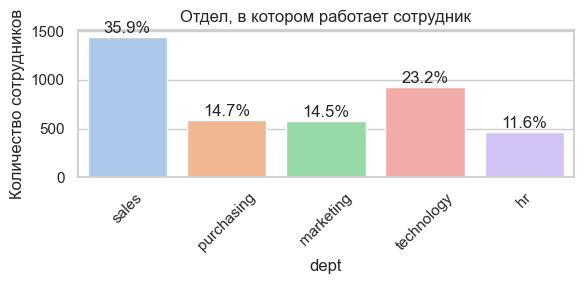

In [79]:
# визуализация признака 'dept'
categorical(data_quit, 'dept', 'Отдел, в котором работает сотрудник')

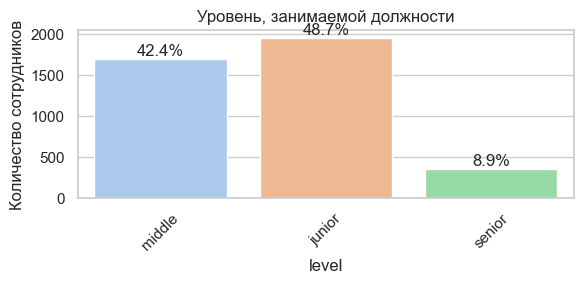

In [80]:
# визуализация признака 'level'
categorical(data_quit, 'level', 'Уровень, занимаемой должности')

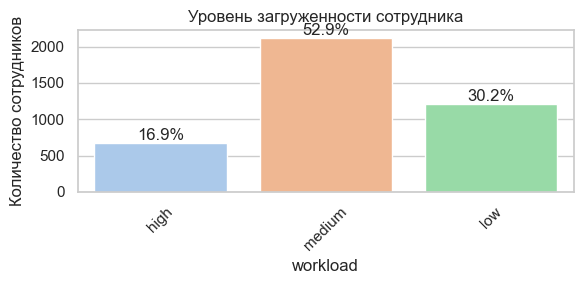

In [81]:
# визуализация признака 'workload'
categorical(data_quit, 'workload', 'Уровень загруженности сотрудника')

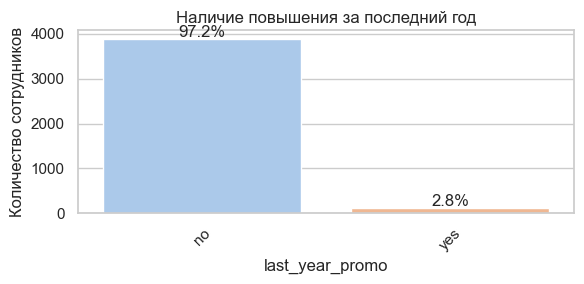

In [82]:
# визуализация признака 'last_year_promo'
categorical(data_quit, 'last_year_promo', 'Наличие повышения за последний год')

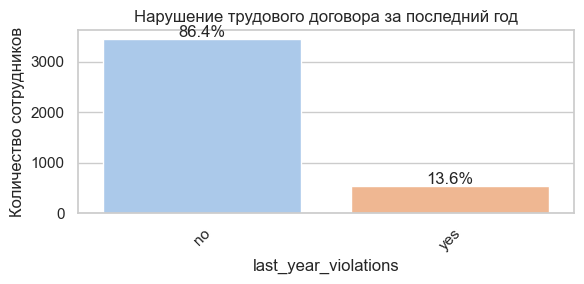

In [83]:
# визуализация признака 'last_year_violations'
categorical(data_quit, 'last_year_violations', 'Нарушение трудового договора за последний год')

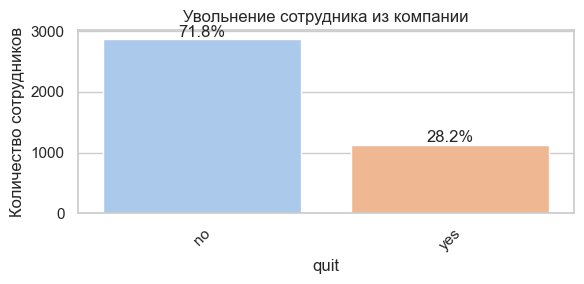

In [84]:
# визуализация целевого признака 'quit'
categorical(data_quit, 'quit', 'Увольнение сотрудника из компании')

In [85]:
# напишем собственную функцию для визуализации категориальных признаков в зависимотсти от значения целевого признака 'quit'
def categorical_pie(data, column, title):
    # устанавливаем параметры графика
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    
    pie_params = {
        'startangle': 90,
        'labeldistance': 1.1,
        'wedgeprops': {'linewidth': 3, 'edgecolor': 'white'},
        'autopct': '%1.1f%%',
        'colors': sns.color_palette('pastel')
    }
    
    # построение круговой диаграммы для уволившихся сотрудников
    yes_data = data[data['quit'] == 'yes'].groupby(column).size()
    ax1.set_title(f'Признак "{column}"\nquit = yes')
    ax1.pie(yes_data, labels=yes_data.index, **pie_params)
    
    # построение круговой диаграммы для оставшихся сотрудников
    no_data = data[data['quit'] != 'yes'].groupby(column).size()
    ax2.set_title(f'Признак "{column}"\nquit = no')
    ax2.pie(no_data, labels=no_data.index, **pie_params)
    
    # окончательная настройка графика
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

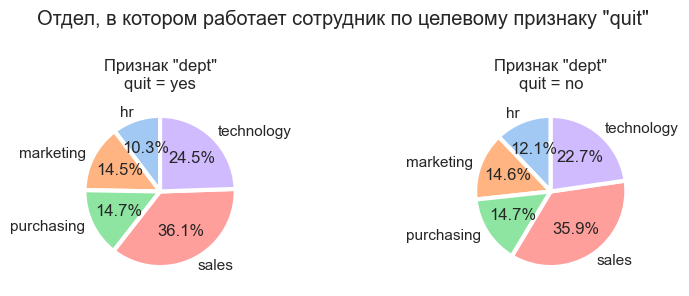

In [86]:
# визуализация признака 'dept' в зависимости от значения целевого признака 'quit'
categorical_pie(data_quit, 'dept', 'Отдел, в котором работает сотрудник по целевому признаку "quit"')

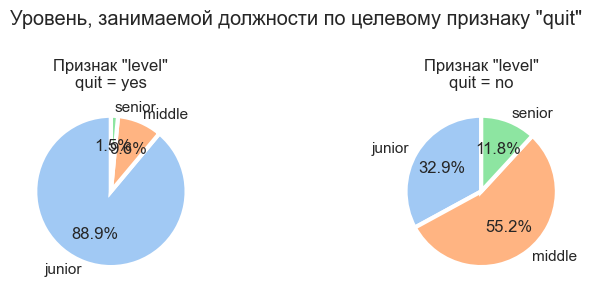

In [87]:
# визуализация признака 'level' в зависимости от значения целевого признака 'quit'
categorical_pie(data_quit, 'level', 'Уровень, занимаемой должности по целевому признаку "quit"')

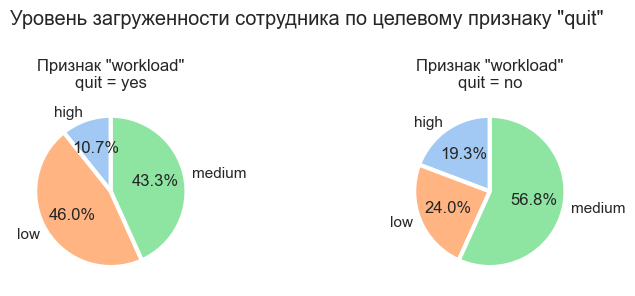

In [88]:
# визуализация признака 'workload' в зависимости от значения целевого признака 'quit'
categorical_pie(data_quit, 'workload', 'Уровень загруженности сотрудника по целевому признаку "quit"')

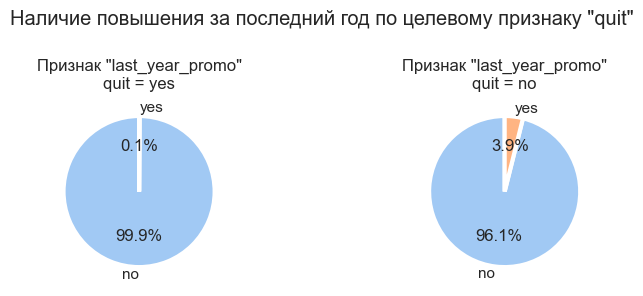

In [89]:
# визуализация признака 'last_year_promo' в зависимости от значения целевого признака 'quit'
categorical_pie(data_quit, 'last_year_promo', 'Наличие повышения за последний год по целевому признаку "quit"')

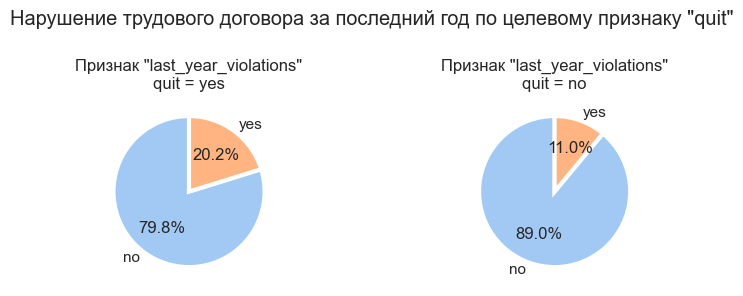

In [90]:
# визуализация признака 'last_year_violations' в зависимости от значения целевого признака 'quit'
categorical_pie(data_quit, 'last_year_violations', 'Нарушение трудового договора за последний год по целевому признаку "quit"')

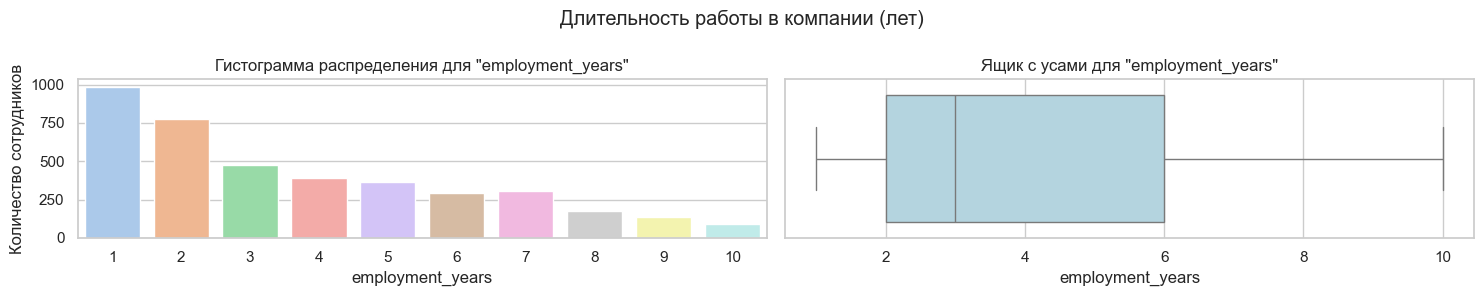

In [91]:
# визуализация признака 'employment_years'
discret(data_quit, 'employment_years', 'Длительность работы в компании (лет)')

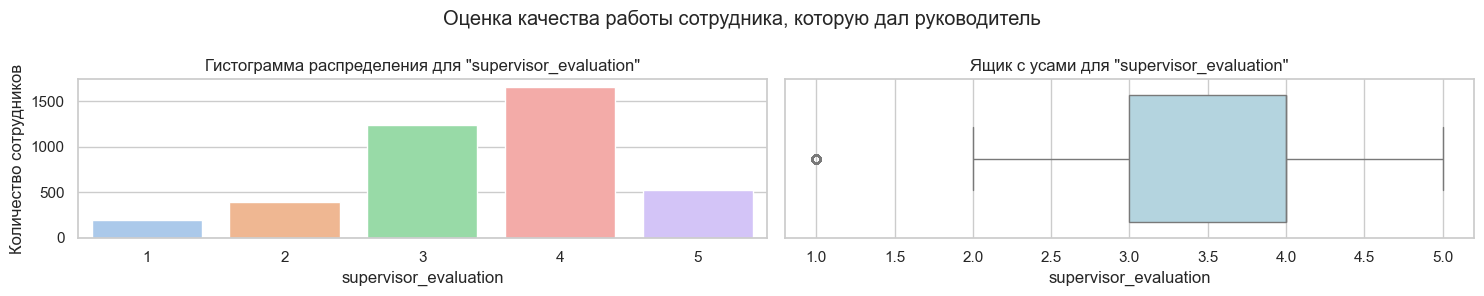

In [92]:
# визуализация признака 'supervisor_evaluation'
discret(data_quit, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель')

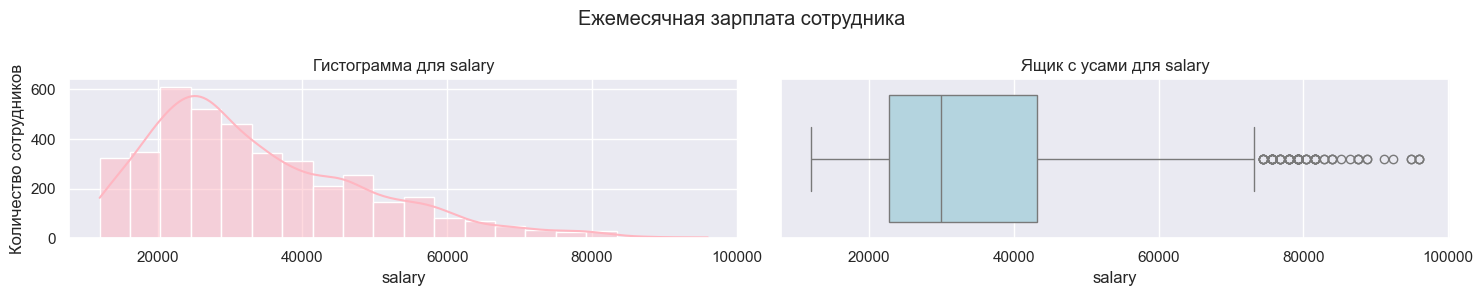

In [93]:
# визуализация признака 'salary'
numeric(data_quit, 'salary', 'Ежемесячная зарплата сотрудника')

In [94]:
# напишем собственную функцию для визуализации дискретных количественных значений признаков в зависимости от значения целевого признака 'quit'
def discret_quit(data, column, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
    
    # построение гистограммы
    sns.countplot(data=data, x=column, hue='quit', palette='pastel', ax=ax1)
    ax1.set_title(f'Гистограмма распределения для "{column}"')
    ax1.set(xlabel=column, ylabel='Частота')
    
    # построение графика "Ящик с усами"
    sns.boxplot(x='quit', y=column, data=data, palette='pastel', ax=ax2)
    ax2.set_title(f'Ящик с усами для "{column}"')
    ax2.set(xlabel='quit', ylabel=column)

    # окончательная настройка графика
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

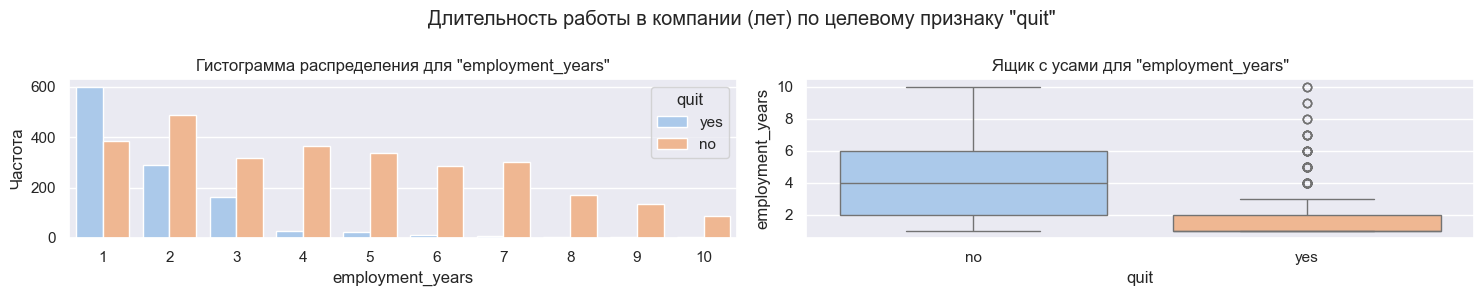

In [95]:
discret_quit(data_quit, 'employment_years', 'Длительность работы в компании (лет) по целевому признаку "quit"')

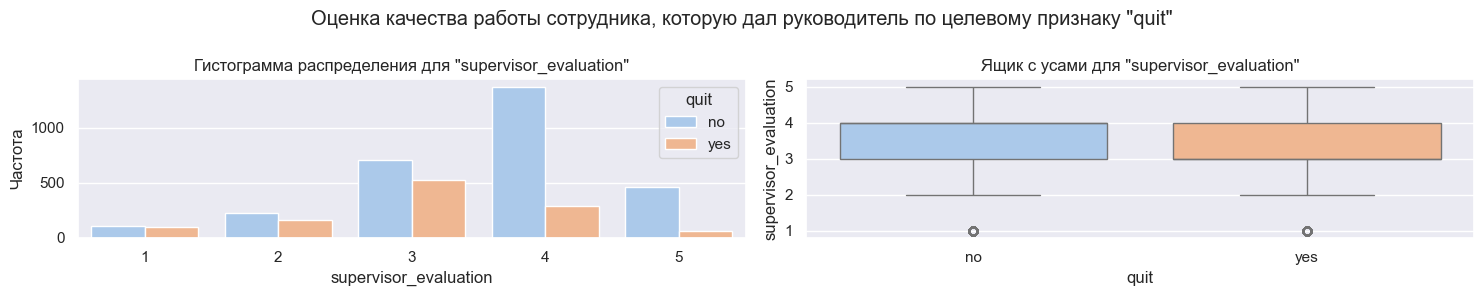

In [96]:
discret_quit(data_quit, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель по целевому признаку "quit"')

In [97]:
# напишем собственную функцию для визуализации непрерывных количественных значений признаков в зависимости от значения целевого признака 'quit'
def numeric_quit(data, column, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # построение гистограммы
    sns.histplot(data=data, x=column, hue='quit', palette='pastel', stat='density', common_norm=False, ax=ax1)
    ax1.set(title=f'Гистограмма распределения для "{column}"', xlabel=column, ylabel='Плотность')
    
    # построение графика "Ящик с усами"
    sns.boxplot(x='quit', y=column, data=data, palette='pastel', ax=ax2)
    ax2.set(title=f'Ящик с усами для "{column}"', xlabel='quit', ylabel=column)
    
    # окончательная настройка графика
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

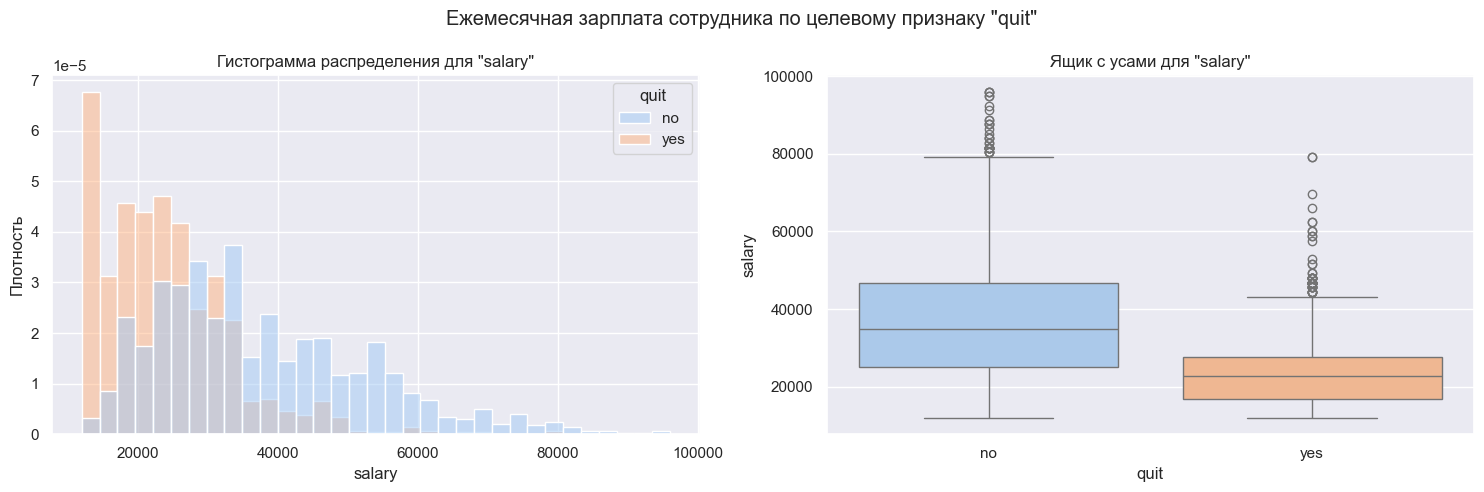

In [98]:
numeric_quit(data_quit, 'salary', 'Ежемесячная зарплата сотрудника по целевому признаку "quit"')

In [99]:
# посмотрим среднее значение зарплаты ушедших сотрудников и тех сотрудников, которые остались в компании
print('Средняя зарплата уволившихся сотрудников:', round(data_quit[data_quit['quit'] == 'yes']['salary'].mean(), 1))
print('Средняя зарплата оставшихся сотрудников:', round(data_quit[data_quit['quit'] != 'yes']['salary'].mean(), 1))

Средняя зарплата уволившихся сотрудников: 23885.1
Средняя зарплата оставшихся сотрудников: 37702.2


**Промежуточные выводы по этапу "Исследовательский анализ данных таблицы 'data_quit'":**

1. Можно сказать, что входящие в таблицу категориальные признаки несбалансированы, прослеживается тенденция, что одни категории встречаются намного чаще других.
2. Дискретные и непрерывные количественные признаки имеют такие же распределения и характерные четы, как и входные признаки, исследуемые в пункте 3.1.
3. Также можно сказать, что сотрудники чаще всего увольняются в течение первых двух годов работы в компании, в случаях, когда руководитель не достаточно высоко или качественно оценивает работу сотрудника, а также в случае наличия низкой заработной платы.
4. Еще для сотрудников, которые увольняются можно сказать:
- увольнения не связаны с тем, в каком отделе работает сотрудник;
- уволившиеся сотрудники в основном занимали должность уровня 'junior';
- уволившиеся в основном имели низкий или средний уровень загруженности;
- у уволившихся сотрудников не было повышений за последний год;
- у уволившихся сотрудников больше нарушений трудового договора, чем у оставшихся.

### 10.2 Исследовательский анализ данных таблицы 'X_test_quit'

In [100]:
# проведем статистический анализ всех признаков в таблице 'X_test_quit'
print('Описательная статистика для количественных признаков:')
X_test_quit.describe(include=[np.number])

Описательная статистика для количественных признаков:


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


**Примечание:** По полученной описательной статистике видно, что данные в столбцах 'employment_years' и 'supervisor_evaluation' являются дискретными, а данные в столбце 'salary' непрерывными, их нужно визуализировать по-разному.

In [101]:
print('Описательная статистика для категориальных признаков:')
X_test_quit.describe(include=['object'])

Описательная статистика для категориальных признаков:


,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


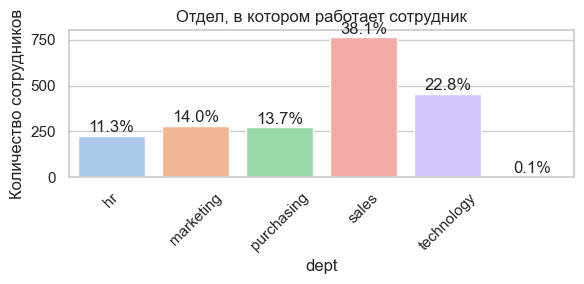

In [102]:
# визуализация признака 'dept'
categorical(X_test_quit, 'dept', 'Отдел, в котором работает сотрудник')

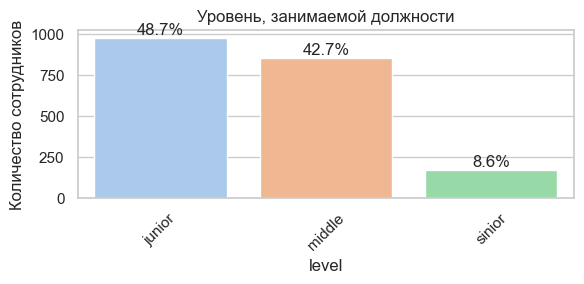

In [105]:
# визуализация признака 'level'
categorical(X_test_quit, 'level', 'Уровень, занимаемой должности')

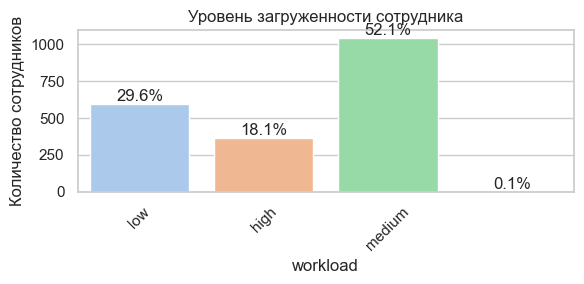

In [106]:
# визуализация признака 'workload'
categorical(X_test_quit, 'workload', 'Уровень загруженности сотрудника')

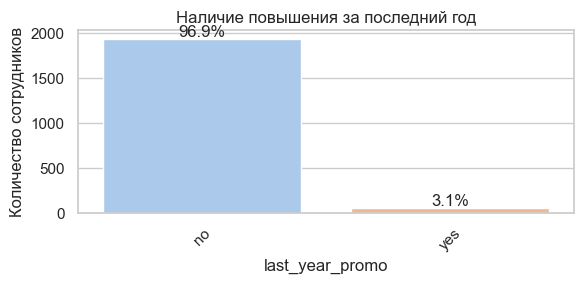

In [109]:
# визуализация признака 'last_year_promo'
categorical(X_test_quit, 'last_year_promo', 'Наличие повышения за последний год')

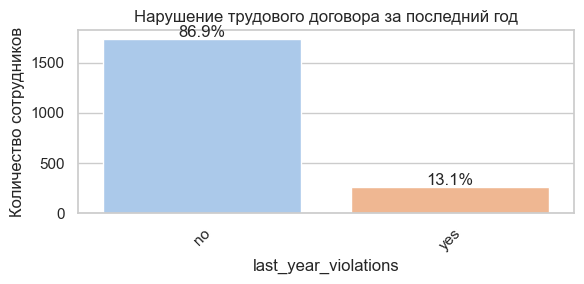

In [110]:
# визуализация признака 'last_year_violations'
categorical(X_test_quit, 'last_year_violations', 'Нарушение трудового договора за последний год')

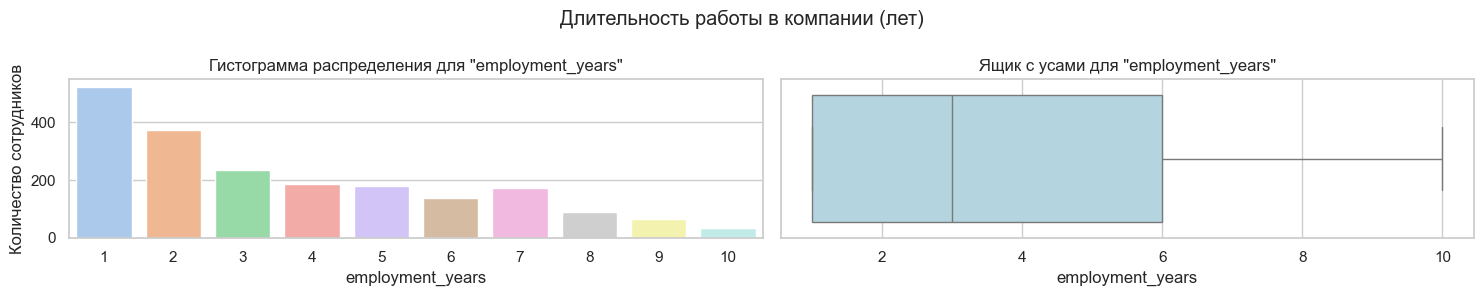

In [111]:
# визуализация признака 'employment_years'
discret(X_test_quit, 'employment_years', 'Длительность работы в компании (лет)')

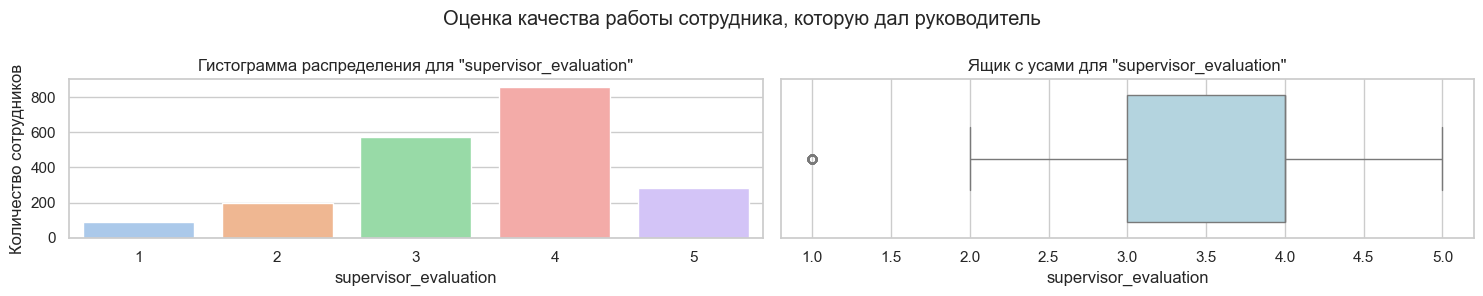

In [112]:
# визуализация признака 'supervisor_evaluation'
discret(X_test_quit, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель')

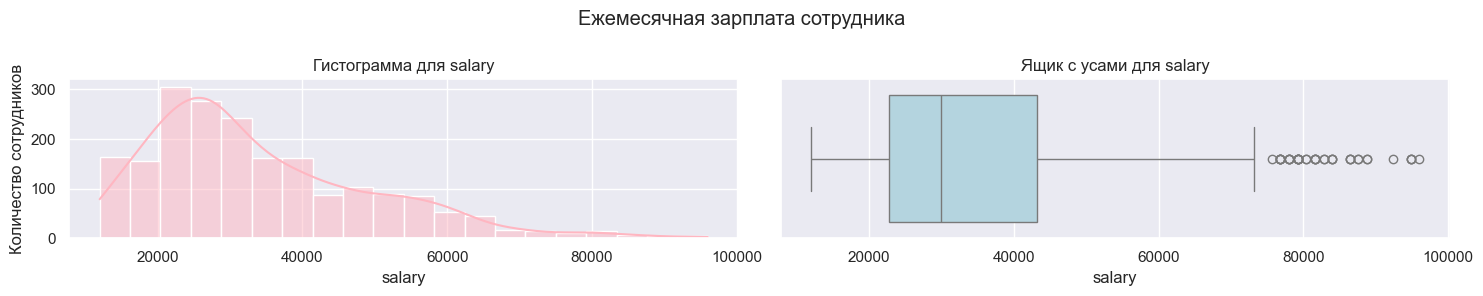

In [113]:
# визуализация признака 'salary'
numeric(X_test_quit, 'salary', 'Ежемесячная зарплата сотрудника')

**Промежуточные выводы по этапу "Исследовательский анализ данных таблицы 'X_test_quit'":**

1. Категориальные признаки в тестовой выборке имеют распределение похожее на то, что получилось на тренировочной выборке.
2. Распределения количественных признаков на тестовой выборке схожи с теми, что получились на тренировочной выборке. Это говорит о том, что предварительная разбивка на тренировочную и тестовую выборки была проведена успешно.

### 10.3 Исследовательский анализ данных таблицы 'y_test_quit'

In [114]:
# проведем статистический анализ всех признаков в таблице 'y_test_quit'
print('Описательная статистика для категориальных признаков:')
y_test_quit.describe(include=['object'])

Описательная статистика для категориальных признаков:


,quit
count,2000
unique,2
top,no
freq,1436


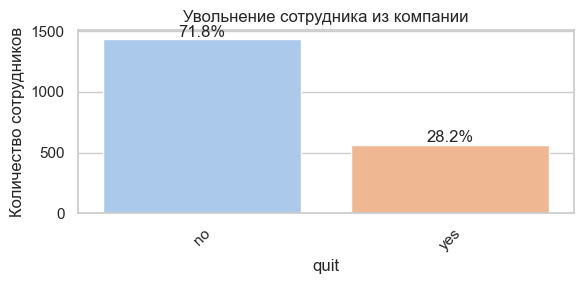

In [115]:
# визуализация признака 'quit'
categorical(y_test_quit, 'quit', 'Увольнение сотрудника из компании')

**Промежуточные выводы по этапу "Исследовательский анализ данных таблицы 'y_test_quit'":**
1. Распределение целевого признака на тестовой выборке схоже с распределением этого же признака на тренировочной выборке.

### 10.4 Анализ зависимости уровеня удовлетворённости сотрудника работой в компании и увольнения сотрудника

In [116]:
# добавим признаки 'job_satisfaction_rate' и 'quit' к входным признакам тестовой выборки
X_test_quit['job_satisfaction_rate'] = y_test
X_test_quit['quit'] = y_test_quit['quit']

# выведем первые 5 строк получившейся таблицы
X_test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,100298,hr,junior,low,2,no,no,4,19200,0.80,no
1,100480,marketing,junior,low,4,no,no,4,16800,0.84,no
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
3,100610,sales,middle,medium,5,no,no,4,43200,0.75,no
4,100692,sales,middle,high,6,no,no,4,48000,0.69,no


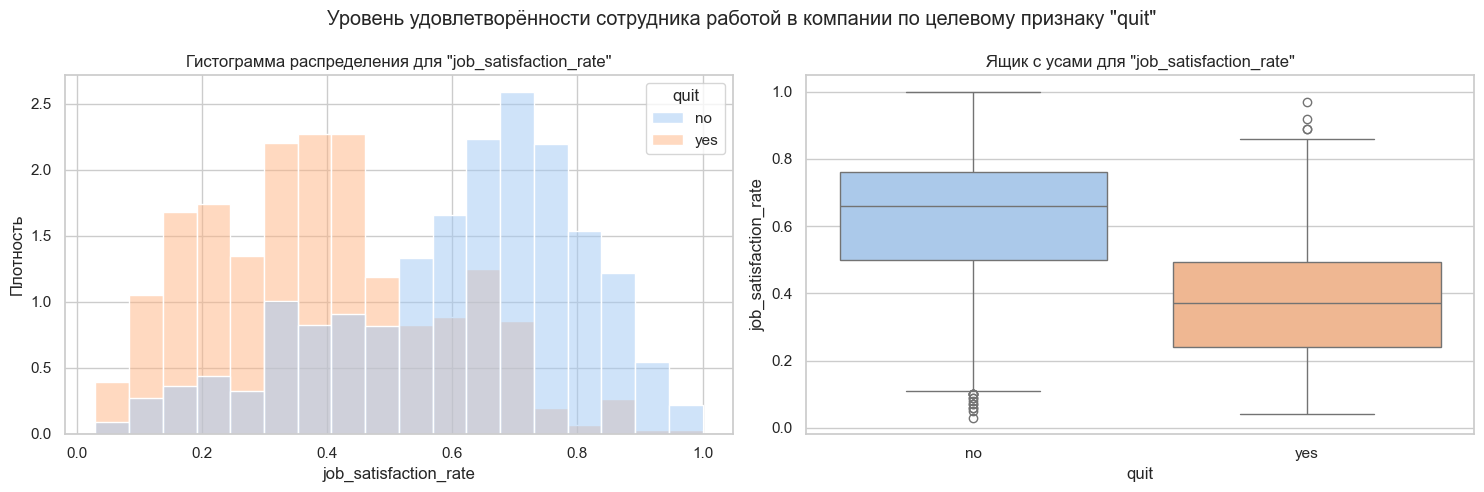

In [117]:
# визуализируем признак 'job_satisfaction_rate' в зависимости от значения 'quit'
numeric_quit(X_test_quit, 'job_satisfaction_rate', 'Уровень удовлетворённости сотрудника работой в компании по целевому признаку "quit"')

Важно понять, есть ли зависимость между уровнем удовлетворенности сотрудника работой и его желанием уволиться из компании. Если да, то непрерывный количественный признак 'job_satisfaction_rate' влияет на целевой признак 'quit', а значит его необходимо добавить в модель.

Сформулируем гипотезы:
- Н0: Средний уровень удовлетворенности работой у уволившихся и оставшихся сотрудников равны.
- Н1: Средний уровень удовлетворенности работой оставшихся сотрудников выше, чем у уволивщихся сотрудников.

In [118]:
# создадим две выборки с уровнем удовлетворенности уволившихся и оставшихся сотрудников
uvol = X_test_quit.query('quit == "yes"')['job_satisfaction_rate']
ost = X_test_quit.query('quit == "no"')['job_satisfaction_rate']

In [119]:
# укажем уровень статистической значимости
alpha = 0.05 

# используем правостороннюю альтернативную гипотезу
results = st.ttest_ind(ost, uvol, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 6.155610332585964e-105
Отвергаем нулевую гипотезу


In [120]:
# проведем проверку результата
print('Средний уровень удовлетворенности у уволившегося сотрудника:', round(uvol.mean(), 2))
print('Средний уровень удовлетворенности у оставшегося сотрудника:', round(ost.mean(), 2))

Средний уровень удовлетворенности у уволившегося сотрудника: 0.39
Средний уровень удовлетворенности у оставшегося сотрудника: 0.61


**Вывод для пункта 10.4 "Анализ зависимости уровеня удовлетворённости сотрудника работой в компании и увольнения сотрудника":** По результатам проверки гипотез мы "отвергаем нудевую гипотезу". Действительно, средний уровень удовлетворенности у оставшегося сотрудника выше, чем у уволившегося сотрудника. А это значит, что правильным решением является добавить признак 'job_satisfaction_rate' к входным признакам для второй задачи.

**Обобщающий вывод этапа "Исследовательский анализ данных":**

1. По полученным результатам можно составить следующий портрет "уволившеося сотрудника":
- увольнения не связаны с тем, в каком отделе работает сотрудник;
- уволившиеся сотрудники в основном занимали должность уровня 'junior';
- уволившиеся в основном имели низкий или средний уровень загруженности;
- у уволившихся сотрудников не было повышений за последний год;
- у уволившихся сотрудников больше нарушений трудового договора, чем у оставшихся;
- уволившиеся сотрудники чаще всего работают в компании в течение небольшого периода времени (1-2 года);
- уволившиеся сотрудники в основном не имеют высоких оценок их работы от руководителя;
- уволившиеся сотрудники в среднем имеют низкую заработную плату.

2. По результатам проверки гипотез, действительно, средний уровень удовлетворенности у оставшегося сотрудника выше, чем у уволившегося сотрудника. А это значит, что правильным решением является добавить признак 'job_satisfaction_rate' к входным признакам для второй задачи.

## 11. Проведение корреляционного анализа данных

### 11.1 Проведение корреляционного анализа признаков таблицы 'data_quit'

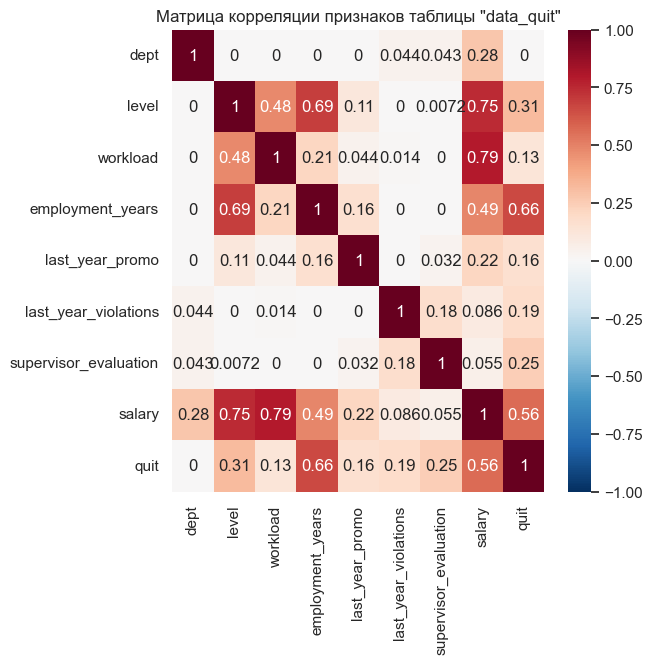

In [121]:
# удалим столбец 'id', так как он не нужен в процессе вычисления корреляции между признаками
data_quit_corr_matrix = data_quit.drop(['id'], axis=1)

# построим корреляционную матрицу, заранее обозначая столбцы с непрерывными количественными значениями
data_quit_corr_matrix = data_quit_corr_matrix.phik_matrix(interval_cols=['salary'])

# проведем визуализацию корреляционной матрицы
# построим тепловую карту
plt.figure(figsize=(6, 6))
sns.heatmap(
    data_quit_corr_matrix,
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)

# окончательная настройка графика
plt.title('Матрица корреляции признаков таблицы "data_quit"')
plt.show()

**Промежуточные выводы по этапу "Проведение корреляционного анализа признаков таблицы 'data_quit'":**

По полученной матрице видно, что:

1. Признаки 'level' (уровень занимаемой должности) и 'employment_years' (длительность работы в компании) имеют высокое значение коэффициента корреляции, равное 0.69.
2. Признаки 'level' (уровень занимаемой должности) и 'salary' (ежемесячная зарплата сотрудника) имеют высокое значение коэффициента корреляции, равное 0.75.
3. Признаки 'salary' (ежемесячная зарплата сотрудника) и 'workload' (уровень загруженности сотрудника) имеют высокое значение коэффициента корреляции, равное 0.79.
4. Целевой признак 'quit' (увольнение сотрудника из компании) и признаки 'employment_years' (длительность работы в компании), 'salary' (ежемесячная зарплата сотрудника) имеют относительно высокие значения коэффициентов корреляции, равные 0.66 и 0.56 соответственно, но данное явление не является мильтиколлинеарностью.

### 11.2 Проведение корреляционного анализа признаков таблицы 'X_test_quit'

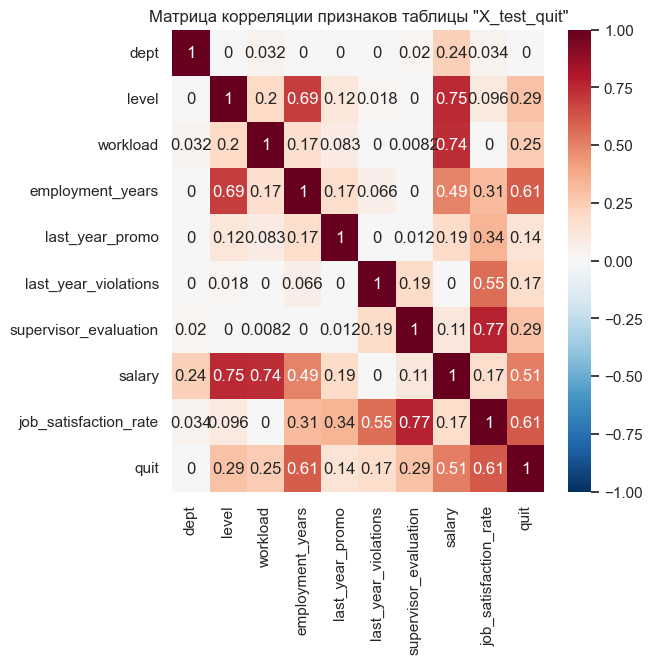

In [122]:
# удалим столбец 'id', так как он не нужен в процессе вычисления корреляции между признаками
X_test_quit_corr_matrix = X_test_quit.drop(['id'], axis=1)

# построим корреляционную матрицу, заранее обозначая столбцы с непрерывными количественными значениями
X_test_quit_corr_matrix = X_test_quit_corr_matrix.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

# проведем визуализацию корреляционной матрицы
# построим тепловую карту
plt.figure(figsize=(6, 6))
sns.heatmap(
    X_test_quit_corr_matrix,
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)

# окончательная настройка графика
plt.title('Матрица корреляции признаков таблицы "X_test_quit"')
plt.show()

**Промежуточные выводы по этапу "Проведение корреляционного анализа признаков таблицы 'X_test_quit'":** Проведенный корреляционный анализ для тестовой выборки продемонстрировал аналогичные результаты, как на тренировочной выборке. Однако целевой признак 'quit' дополнительно стал иметь достаточно высокий коэффициент корреляции с новым признаком 'job_satisfaction_rate', равный 0.61.

**Обобщающий вывод этапа "Проведение корреляционного анализа":**

Для признаков таблицы 'data_quit' (тренировочная выборка):
1. Признаки 'level' (уровень занимаемой должности) и 'employment_years' (длительность работы в компании) имеют высокое значение коэффициента корреляции, равное 0.69.
2. Признаки 'level' (уровень занимаемой должности) и 'salary' (ежемесячная зарплата сотрудника) имеют высокое значение коэффициента корреляции, равное 0.75.
3. Признаки 'salary' (ежемесячная зарплата сотрудника) и 'workload' (уровень загруженности сотрудника) имеют высокое значение коэффициента корреляции, равное 0.79.
4. Целевой признак 'quit' (увольнение сотрудника из компании) и признаки 'employment_years' (длительность работы в компании), 'salary' (ежемесячная зарплата сотрудника) имеют относительно высокие значения коэффициентов корреляции, равные 0.66 и 0.56 соответственно, но данное явление не является мильтиколлинеарностью.

Для признаков таблицы 'X_test_quit' (тестовая выборка): Проведенный корреляционный анализ для тестовой выборки продемонстрировал аналогичные результаты, как на тренировочной выборке. Однако целевой признак 'quit' дополнительно стал иметь достаточно высокий коэффициент корреляции с новым признаком 'job_satisfaction_rate', равный 0.61. А это значит, что признак был добавлен в модель правильно.

## 12. Подготовка данных

In [123]:
# удалим из таблицы, содержащую тренировочную выборку столбец 'id'
pre_data_quit = data_quit.drop('id', axis=1)

**Примечание:** Так как столбец 'id' с неповторяющимися значениями индексов был удален, происходит уменьшение количества исследуемых значений в целом. В связи с этим могут появиться новые явные дубликаты. Это необходимо проверить и удалить при появлении.

In [124]:
# проверим новую таблицу на наличие явных дубликатов
pre_data_quit.duplicated().sum()

np.int64(1413)

In [125]:
# удалим все явные дубликаты в новой таблице, так как они будут мешать дальнейшему качественному построению моделей
pre_data_quit = pre_data_quit.drop_duplicates()

# проверим новую таблицу на наличие явных дубликатов
pre_data_quit.duplicated().sum()

np.int64(0)

In [126]:
# удалим ранее добавленный целевой признак из тестовой выборки
X_train_quit = pre_data_quit.drop('quit', axis=1)

# предскажем уровень удовлетворенности, полученный в процессе реализации цели №1, для новой тестовой выборки
y = grid_search.predict(X_train_quit) 

# добавим новый признак 'job_satisfaction_rate' в список входных признаков
X_train_quit['job_satisfaction_rate'] = pd.DataFrame(y)

# выведем первые 5 строк новой таблицы
X_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.660000
1,sales,junior,medium,2,no,no,4,27600,0.853529
2,purchasing,middle,medium,5,no,no,1,37200,0.364091
3,sales,junior,medium,2,no,yes,3,24000,0.380000
4,marketing,junior,medium,2,no,no,5,25200,0.690000


**Обобщающий вывод этапа "Подготовка данных":** На данном этапе была проведена подготовка данных для дальнейшего обучения.

## 13. Обучение моделей

### 13.1 Создание пайплайна и обучение моделей

In [127]:
# создаем тренировочную и тестовую выборки на основе исходных данных
# создаем тренировочную выборку
X_train_quit = X_train_quit
y_train_quit = pre_data_quit['quit']
# создаем тестовую выборку
X_test_quit = X_test_quit.drop(['id', 'quit'], axis=1)
y_test_quit = y_test_quit['quit']

# создаем списки с названиями признаков
ohe_columns_quit = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns_quit = ['level', 'workload']

num_columns_quit = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# создаем пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe_quit = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

# создаем пайплайн для подготовки признаков из списка ord_columns
ord_pipe_quit = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor_quit = ColumnTransformer(
    [
        ('ohe', ohe_pipe_quit, ohe_columns_quit),
        ('ord', ord_pipe_quit, ord_columns_quit),
        ('num', StandardScaler(), num_columns_quit)
    ], 
    remainder='passthrough'
)

# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_quit = Pipeline(
    [
        ('preprocessor', 
         data_preprocessor_quit
        ),
        ('models', 
        DecisionTreeClassifier(random_state=RANDOM_STATE)
        )
    ]
)

param_grid_quit = [

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10, 15, None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

grid_search_quit = GridSearchCV(
    pipe_final_quit, 
    param_grid_quit, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# обучение модели на основе тренировочной выборки
grid_search_quit.fit(X_train_quit, y_train_quit)

print('Лучшая модель и её параметры:\n\n', grid_search_quit.best_estimator_)
print ('Метрика ROC-AUC для лучшей модели по кросс-валидации на основе обучающих данных:', grid_search_quit.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [128]:
# проверим работу модели на тестовой выборке
# выполним предсказание вероятностей
y_test_proba = grid_search_quit.predict_proba(X_test_quit)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_proba[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9125624765404294


### 13.2 Анализ важности признаков

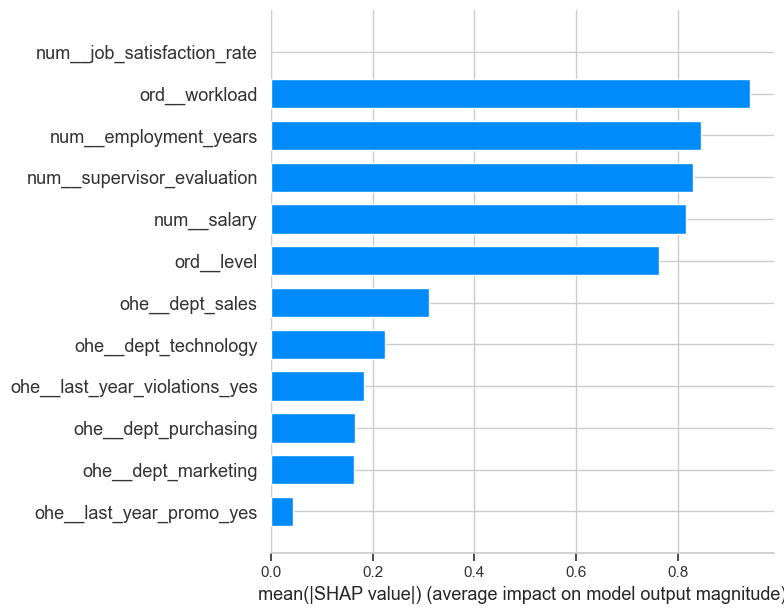

In [129]:
# достанем компоненты пайплайна
X_encoded_quit = grid_search_quit.best_estimator_['preprocessor'].fit_transform(X_train_quit)
# преобразуем данные и обучаем модель
model_quit = grid_search_quit.best_estimator_['models'].fit(X_encoded_quit, y_train_quit)

# создаем "Еxplainer"
explainer_quit = shap.PermutationExplainer(model_quit, X_encoded_quit)
# получим названия наших признаков
labels_quit = grid_search_quit.best_estimator_[:-1].get_feature_names_out()

# проводим визуализацию важности признаков
shap.summary_plot(X_encoded_quit, plot_type='bar', feature_names=labels_quit)

## 14. Итоговый вывод по цели №2 "Предсказание увольнения сотрудника из компании"

**Обобщающий вывод по цели №2 "Предсказание увольнения сотрудника из компании":**

1. Наилучшей моделью оказалась **DecisionTreeClassifier()** с параметрами: (max_depth=5, random_state=42).
2. Метрика ROC-AUC на тестовой выборке равна 0.91, что удовлетворяет требованиям реализации цели, так как по условиям метрика ROC-AUC ≥ 0.91 на тестовой выборке.
3. После реализации этапа "Анализ важности признаков" стало видно, что наиболее важными признаками при построении модели, которые влияют на целевой признак, являются 'workload' (уровень загруженности сотрудника), 'employment_years' (длительность работы в компании (лет)) и 'supervisor_evaluation' (оценка качества работы сотрудника, которую дал руководитель).
4. Можно предположить, что среди двух рассмотренных моделей эта оказалась лучше, чем DecisionTreeClassifier(), потому что, возможно, могут присутствовать нелинейные зависимости между входными признаками и целевым признаком.

## 15. Итоговые выводы

В ходе работы были проанализированы данные, предоставленные компанией «Работа с заботой», которая хочет разработать модели, позволяющие предсказывать уровень удовлетворенности сотрудника и факт увольнения сотрудника из компании.

Было реализовано 14 этапов работы для двух поставленных целей (этапы были похожими для обеих).

На **1 этапе: Загрузка и изучение данных** были проанализированы все исходные данные с входными признаками, дале на **2 этапе: Предобработка данных** были обработаны все неточности в загруженных таблицах, а именно: заменена опечатка, обнаружены пропуски и произведена сортировка по индексам.


Для обоих целей на **3 этапе: Исследовательский анализ данных** были похожи схожие результаты, а именно:
1. Среди категориальных признаков присутствует дисбаланс, о чем говорит факт того, что некоторые категории встречаются значительно чаще других.
2. Распределения количественных признаков на тестовой выборке схожи с теми, что получились на тренировочной выборке. Это говорит о том, что предварительная разбивка на тренировочную и тестовую выборки была проведена успешно.
3. Распределение целевого признака на тестовой выборке схоже с распределением этого же признака на тренировочной выборке.

На **4 этапе: Проведение корреляционного анализа данных** для обоих целей были получены следующие результаты:
1. Признаки 'level' (уровень занимаемой должности) и 'employment_years' (длительность работы в компании) имеют высокое значение коэффициента корреляции, равное 0.68.
2. Признаки 'level' (уровень занимаемой должности) и 'salary' (ежемесячная зарплата сотрудника) имеют высокое значение коэффициента корреляции, равное 0.72.
3. Признаки 'salary' (ежемесячная зарплата сотрудника) и 'workload' (уровень загруженности сотрудника) имеют высокое значение коэффициента корреляции, равное 0.79.

На **5 этапе: Подготовка данных** для каждой из целей была проведена подготовка данных для дальнейшего обучения.

На **6 этапе: Обучение моделей** были получены следующие результаты:

Для **Цель №1 "Предсказание уровня удовлетворенности сотрудника"**:
1. Наилучшей моделью оказалась **DecisionTreeRegressor()** с параметрами: (max_depth=12, max_features=8, random_state=42))]).
2. Метрика SMAPE на тестовой выборке равна 14.91, что удовлетворяет требованиям реализации цели, так как по условия метрика SMAPE ≤ 15 на тестовой выборке.
3. По графику "Важность признаков модели" стало видно, что наиболее важными признаками при построении модели, которые влияют на целевой признак, являются 'supervisor_evaluation' (оценка качества работы сотрудника, которую дал руководитель), 'employment_years' (длительность работы в компании (лет)) и 'level' (уровень занимаемой должности).
4. Можно предположить, что среди двух рассмотренных моделей эта оказалась лучше, чем LinearRegression(), потому что, возможно, могут присутствовать нелинейные зависимости между входными признаками и целевым признаком.

Для **Цель №2 "Предсказание увольнения сотрудника из компании"**:
1. Наилучшей моделью оказалась **DecisionTreeClassifier()** с параметрами: (max_depth=5, max_features=9, random_state=42))]).
2. Метрика ROC-AUC на тестовой выборке равна 0.91, что удовлетворяет требованиям реализации цели, так как по условиям метрика ROC-AUC ≥ 0.91 на тестовой выборке.
3. После реализации этапа "Анализ важности признаков" стало видно, что наиболее важными признаками при построении модели, которые влияют на целевой признак, являются 'workload' (уровень загруженности сотрудника), 'employment_years' (длительность работы в компании (лет)) и 'supervisor_evaluation' (оценка качества работы сотрудника, которую дал руководитель).
4. Можно предположить, что среди двух рассмотренных моделей эта оказалась лучше, чем DecisionTreeClassifier(), потому что, возможно, могут присутствовать нелинейные зависимости между входными признаками и целевым признаком.

Также для цели №2 удалось составить портрет "уволившегося сотрудника":
- увольнения не связаны с тем, в каком отделе работает сотрудник;
- уволившиеся сотрудники в основном занимали должность уровня 'junior';
- уволившиеся в основном имели низкий или средний уровень загруженности;
- у уволившихся сотрудников не было повышений за последний год;
- у уволившихся сотрудников больше нарушений трудового договора, чем у оставшихся;
- уволившиеся сотрудники чаще всего работают в компании в течение небольшого периода времени (1-2 года);
- уволившиеся сотрудники в основном не имеют высоких оценок их работы от руководителя;
- уволившиеся сотрудники в среднем имеют низкую заработную плату;
- уровень удовлетворенности работой в компании тоже влияет на факт увольнения сотрудника из компании.

**Предложения для бизнеса:** Для уменьшения увольнений сотрудников, конечно, необходимо увеличивать уровень их удовлетворенности работой в компании, а именно проведить меры по повышению квалификации, и в том числе по повышению должностных обязанностей, а значит и должности в целом; повышать заработную плату оставшимся сотрудникам. А чтобы снизить уровень увольнений сотрудников в первые два года работы в компании, необходимо повышать нагрузку сотрудников постепенно, чтобы не было выгораний, а если нужны сотрудники для более сложных задач, значит сразу нанимать сотрудников на уровень выше, чтобы они удовлетворяли потребностям компании.